In [1]:
import copy
import numpy as np
import numpy.ma as ma
from scipy.io import netcdf as nc
from scipy.interpolate import griddata
from scipy import stats
import netCDF4 as nc4
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import ticker, cm, colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import numba
from numba import njit
import time
import sys
import altair as alt
import glob
import os
import matplotlib.animation as animation
from IPython.display import HTML

### Options

In [2]:
## Inputs from user
## Some constants
yr_beg = 1850
nyr = 166
nlat = 46
nlon = 72

### Use NetCDF4 to open dataset

In [3]:
## Get and open the history file
## Change the line below to point to the file that you've made,
start = time.time()

# Should be a concatenated monthly FATES history files into a single file
# filename_in = 'fates.nor_spinup.elm.h0.1850_2000.nc'
# Global variables and switches
verbose = True
make_movie = False

filename_in = 'D:/FATES_cases/fates.har_c.1850_2015.compressed.nc'
ds = nc4.Dataset(filename_in)
    
## read in variables
## Climate
tbot = ds['TBOT'][:]
# 2m air temperature calculated from LSM
t2m = ds['TSA'][:]
fates_area_frac = ds['FATES_FRACTION'][:]

## Biogeophysics
ref_sr = ds['FSR'][:]
ref_sr_d = ds['FSRVD'][:]
ref_sr_i = ds['FSRVI'][:]
abs_sr = ds['FSA'][:]
tot_sr = ds['FSDS'][:]
tot_sr_d = ds['FSDSVD'][:]
tot_sr_i = ds['FSDSVI'][:]
tot_sh = ds['FSH'][:]
rad_err = ds['FATES_RAD_ERROR'][:]
tot_lh = ds['EFLX_LH_TOT'][:]
tot_gh = ds['FGR'][:]
# eg = ds['FGEV'][:]
eg = ds['QSOIL'][:]
# t = ds['FCTR'][:]
t = ds['QVEGT'][:]
# ec = ds['FCEV'][:]
ec = ds['QVEGE'][:]
et = eg + t + ec

## Macro-ecology
vegc = ds['FATES_VEGC'][:]
litterc = ds['LITTERC'][:]
vegc_pf = ds['FATES_VEGC_PF'][:]
area_plants = ds['FATES_AREA_PLANTS'][:]
structc = ds['FATES_STRUCTC'][:]
nonstructc = ds['FATES_NONSTRUCTC'][:]
leafc = ds['FATES_LEAFC'][:]
# C fluxes
gpp = ds['FATES_GPP'][:]
gpp_sec = ds['FATES_GPP_SECONDARY'][:]
gpp_pf = ds['FATES_GPP_PF'][:]
npp = ds['FATES_NPP'][:]
nep = ds['FATES_NEP'][:]
# nbp = ds['NBP'][:]
hr = ds['FATES_HET_RESP'][:]
litc_in = ds['FATES_LITTER_IN'][:]
litc_out = ds['FATES_LITTER_OUT'][:]
    
## Demography
# Nplant
np_pf = ds['FATES_NPLANT_PF'][:]
np_sz = ds['FATES_NPLANT_SZ'][:]

# Recruitment
recru_pf = ds['FATES_RECRUITMENT_PF'][:]

# Germinated Seed
sg = ds['FATES_SEED_GERM_EL'][:]

# Crown area to calculate dominant PFT
cr_area_pf = ds['FATES_CROWNAREA_PF'][:]
ca_area_ap = ds['FATES_CANOPYAREA_AP'][:]
cr_area_cl = ds['FATES_CROWNAREA_CL'][:]
hite = ds['FATES_CA_WEIGHTED_HEIGHT'][:]
elai = ds['ELAI'][:]
tlai = ds['TLAI'][:]

# No-comp mode only, please comment this out if not no-comp mode result
area_pf_nocomp = ds['FATES_NOCOMP_PATCHAREA_PF'][:]
    
# LUC related
# # Requires huge memory
# # Do not read if not necessary
# hrvflux = ds['FATES_HARVEST_CARBON_FLUX'][:]
# # prod10c = ds['PROD10C'][:]
# # prod100c = ds['PROD100C'][:]
# # hrv10flux = ds['HRV_DEADSTEMC_TO_PROD10C'][:]
# hrv100flux = ds['HRV_DEADSTEMC_TO_PROD100C'][:]
hrvc = ds['FATES_WOOD_PRODUCT'][:]
hrv_debt = ds['FATES_HARVEST_DEBT'][:]
hrv_debt_sec_m = ds['FATES_HARVEST_DEBT_SEC_MATURE'][:]
hrv_debt_sec_y = ds['FATES_HARVEST_DEBT_SEC_YOUNG'][:]

# Secondary forest related (fraction and age distribution)
sec_frac = ds['FATES_SECONDARY_FOREST_FRACTION'][:]
sec_biomass = ds['FATES_VEGC_SE_PF'][:]
canopy_area_ap = ds['FATES_CANOPYAREA_AP'][:]
parea_ap = ds['FATES_PATCHAREA_AP'][:]
pfarea = ds['FATES_NOCOMP_PATCHAREA_PF'][:]
    
ds.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
lat_4x5 = latnc
lon_4x5 = lonnc

# Open half degree land mask
filename_in_maskinput = 'halfdeg_landmask.nc'
ds = nc4.Dataset(filename_in_maskinput)
landfrac_halfdeg = ds['LANDFRAC_PFT'][:]
ds.close()

land_dot5xdot5 = copy.deepcopy(landfrac_halfdeg)

# Open 1 degree land mask
filename_in_maskinput = 'landmask_topo_1deg.nc'
ds = nc4.Dataset(filename_in_maskinput)
landfrac_onedeg = ds['topo'][:]
ds.close()

landfrac_onedeg[landfrac_onedeg>0] = 1
land_1x1 = copy.deepcopy(landfrac_onedeg)

end = time.time()

print('Time elapsed: ', end - start)


('Time elapsed: ', 24.143999814987183)


C:\Users\sshu3\Anaconda2\lib\site-packages\scipy\io\netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


## Evaluation of FATES physical variables against multiple observations

### Basic variables used in calculations

In [5]:
# Global grid area for 0.5 deg 
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
earth_area = 5.1e14
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Global grid area for 1.0 deg 
nlon = 360
nlat = 180
grid_area_1d = np.ones((nlat, nlon))*-9999.
earth_area = 5.1e14
lat = np.arange(-89.5, 90.5, 1.0)
res = 1.0;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area_1d[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Global land area for 0.5 deg. Used for calculating the area-weighted average 
# and fill the masked desert regions in zonal calculation
land_area = copy.deepcopy(grid_area[:,:])
land_area[land_dot5xdot5<=0.0] = np.float('nan')
land_area_1d = copy.deepcopy(grid_area_1d[:,:])
land_area_1d[land_1x1<=0.0] = np.float('nan')

### forest biomass

In [6]:
# Open biomass observations
# Tropical
filename_in = 'biomass_data_ilamb/tropical_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
tropical_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
tropical_for_c = np.nanmean(tropical_for_c_tmp[:,:,:], axis=0)

# ESACCI
filename_in = 'biomass_data_ilamb/esacci_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
esacci_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
esacci_for_c = np.nanmean(esacci_for_c_tmp[:,:,:], axis=0)

# Geo Carbon
filename_in = 'biomass_data_ilamb/geocarbon.nc'
ds = nc4.Dataset(filename_in)
geocarbon_for_c_tmp = ds.variables['biomass'][:]
ds.close()
 
geocarbon_for_c = np.nanmean(geocarbon_for_c_tmp[:,:,:], axis=0)

# Global Carbon
filename_in = 'biomass_data_ilamb/global_carbon_v3.nc'
fin = nc.netcdf_file(filename_in)
gc_lat = fin.variables['lat'][:]
gc_lon = fin.variables['lon'][:]
## read in variables
gc_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
gc_for_c = np.nanmean(gc_for_c_tmp[:,:,:], axis=0)

# NBCD2000
filename_in = 'biomass_data_ilamb/nbcd2000_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
nbcd2000_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
nbcd2000_for_c = np.nanmean(nbcd2000_for_c_tmp[:,:,:], axis=0)

# US Forest
filename_in = 'biomass_data_ilamb/US_forest_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
usf_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
usf_for_c = np.nanmean(usf_for_c_tmp[:,:,:], axis=0)

# Thurner
filename_in = 'biomass_data_ilamb/Thurner_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
thurner_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
thurner_for_c = np.nanmean(thurner_for_c_tmp[:,:,:], axis=0)

# Xu-Saatchi
filename_in = 'biomass_data_ilamb/XuSaatchi.nc'
ds = nc4.Dataset(filename_in)
xusaatchi_for_c_tmp = ds.variables['biomass'][:]
ds.close()

xusaatchi_for_c = np.nanmean(xusaatchi_for_c_tmp[:,:,:], axis=0)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


In [7]:
sel_yr = 151
# Get the latitudinal mean of the forest (PFT 1-9) biomass of all datasets
vegc_pf_copy = copy.deepcopy(vegc_pf)
vegc_pf_copy[vegc_pf_copy>1e2] = np.float('nan')
vegc_pf_copy[vegc_pf_copy<0] = np.float('nan')
vegc_fates = np.sum(vegc_pf_copy[(12*nyr-1),0:12,:,:], 0)
vegc_fates_for = np.sum(vegc_pf_copy[(12*nyr-1),0:9,:,:], 0)
vegc_1 = vegc_pf_copy[(12*sel_yr-1),0,:,:]
vegc_2 = vegc_pf_copy[(12*sel_yr-1),1,:,:]
vegc_3 = vegc_pf_copy[(12*sel_yr-1),2,:,:]
vegc_4 = vegc_pf_copy[(12*sel_yr-1),3,:,:]
vegc_5 = vegc_pf_copy[(12*sel_yr-1),4,:,:]
vegc_6 = vegc_pf_copy[(12*sel_yr-1),5,:,:]
vegc_7 = vegc_pf_copy[(12*sel_yr-1),6,:,:]
vegc_8 = vegc_pf_copy[(12*sel_yr-1),7,:,:]
vegc_9 = vegc_pf_copy[(12*sel_yr-1),8,:,:]
vegc_copy = copy.deepcopy(vegc)
vegc_copy[vegc_copy>1e5] = np.float('nan')
vegc_copy[vegc_copy<=0] = np.float('nan')
vegc_fates_for[vegc_fates_for>1e5] = np.float('nan')
vegc_fates_for[vegc_fates_for<=0] = np.float('nan')
vegc_fates_all = vegc_copy[(12*nyr-1),:,:]
vegc_for_area = np.nansum(pfarea[12*sel_yr-1,0:9,:,:], 0)

# FATES
vegc_lat = np.nanmean(vegc_fates, 1)
vegc_lat_for = np.nanmean(vegc_fates_for, 1)
vegc_for_area_lat = np.nanmean(vegc_for_area, 1)
vegc_all_lat = np.nanmean(vegc_fates_all, 1)
vegc_all_lat[vegc_all_lat<=0] = np.float('nan')
vegc_all_lat_tot = np.nanmean(vegc_fates_all*area_4x5/1e6, 1)
vegc_1_lat = np.nanmean(vegc_1, 1)
vegc_2_lat = np.nanmean(vegc_2, 1)
vegc_3_lat = np.nanmean(vegc_3, 1)
vegc_4_lat = np.nanmean(vegc_4, 1)
vegc_5_lat = np.nanmean(vegc_5, 1)
vegc_6_lat = np.nanmean(vegc_6, 1)
vegc_7_lat = np.nanmean(vegc_7, 1)
vegc_8_lat = np.nanmean(vegc_8, 1)
vegc_9_lat = np.nanmean(vegc_9, 1)
vegc_for_lat = vegc_1_lat + vegc_2_lat + vegc_3_lat + vegc_4_lat + vegc_5_lat + vegc_6_lat
# Do not plot the region outside observation's range, these gridcells are all 0.
vegc_for_lat[0:10] = np.float('nan')

# Other obs
tropical_for_c_copy = copy.deepcopy(tropical_for_c)
tropical_for_c_copy[tropical_for_c_copy<=0] = np.float('nan')
tropical_for_c_copy[tropical_for_c_copy>1e5] = np.float('nan')
geocarbon_for_c_copy = copy.deepcopy(geocarbon_for_c)
geocarbon_for_c_copy[geocarbon_for_c_copy<=0] = np.float('nan')
geocarbon_for_c_copy[geocarbon_for_c_copy>1e5] = np.float('nan')
esacci_for_c_copy = copy.deepcopy(esacci_for_c)
esacci_for_c_copy[esacci_for_c_copy<=0] = np.float('nan')
esacci_for_c_copy[esacci_for_c_copy>1e5] = np.float('nan')
gc_for_c_copy = copy.deepcopy(gc_for_c)
gc_for_c_copy[gc_for_c_copy>1e5] = np.float('nan')
gc_for_c_copy[gc_for_c_copy<=0] = np.float('nan')
nbcd2000_for_c_copy = copy.deepcopy(nbcd2000_for_c)
nbcd2000_for_c_copy[nbcd2000_for_c_copy<=0] = np.float('nan')
nbcd2000_for_c_copy[nbcd2000_for_c_copy>1e5] = np.float('nan')
usf_for_c_copy = copy.deepcopy(usf_for_c)
usf_for_c_copy[usf_for_c_copy<=0] = np.float('nan')
usf_for_c_copy[usf_for_c_copy>1e5] = np.float('nan')
thurner_for_c_copy = copy.deepcopy(thurner_for_c)
thurner_for_c_copy[thurner_for_c_copy<=0] = np.float('nan')
thurner_for_c_copy[thurner_for_c_copy>1e5] = np.float('nan')
xusaatchi_for_c_copy = copy.deepcopy(xusaatchi_for_c)
xusaatchi_for_c_copy[xusaatchi_for_c_copy<=0] = np.float('nan')
xusaatchi_for_c_copy[xusaatchi_for_c_copy>1e5] = np.float('nan')

tropical_lat = np.nanmean(tropical_for_c_copy, 1)
tropical_lat[tropical_lat<=0] = np.float('nan')
geocarbon_lat = np.nanmean(geocarbon_for_c_copy, 1)
geocarbon_lat[geocarbon_lat<=0] = np.float('nan')
esacci_lat = np.nanmean(esacci_for_c_copy, 1)
esacci_lat[esacci_lat<=0] = np.float('nan')
gc_lat = np.nanmean(gc_for_c_copy, 1)
gc_lat[gc_lat<=0] = np.float('nan')
nbcd2000_lat = np.nanmean(nbcd2000_for_c_copy, 1)
nbcd2000_lat[nbcd2000_lat<=0] = np.float('nan')
usf_lat = np.nanmean(usf_for_c_copy, 1)
usf_lat[usf_lat<=0] = np.float('nan')
thurner_lat = np.nanmean(thurner_for_c_copy, 1)
thurner_lat[thurner_lat<=0] = np.float('nan')
xusaatchi_lat = np.nanmean(xusaatchi_for_c_copy, 1)
xusaatchi_lat[xusaatchi_lat<=0] = np.float('nan')

tropical_lat_tot = np.nanmean(tropical_for_c_copy*grid_area/1e12, 1)
geocarbon_lat_tot = np.nanmean(geocarbon_for_c_copy[:,0:720]*grid_area[59:340,:]/1e12, 1)
esacci_lat_tot = np.nanmean(esacci_for_c_copy[:,0:720]*grid_area[59:340,:]/1e12, 1)
gc_lat_tot = np.nanmean(gc_for_c_copy*grid_area/1e12, 1)
nbcd2000_lat_tot = np.nanmean(nbcd2000_for_c_copy*grid_area/1e12, 1)
usf_lat_tot = np.nanmean(usf_for_c_copy*grid_area/1e12, 1)
thurner_lat_tot = np.nanmean(thurner_for_c_copy*grid_area/1e12, 1)
xusaatchi_lat_tot = np.nanmean(xusaatchi_for_c_copy*grid_area/1e12, 1)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py

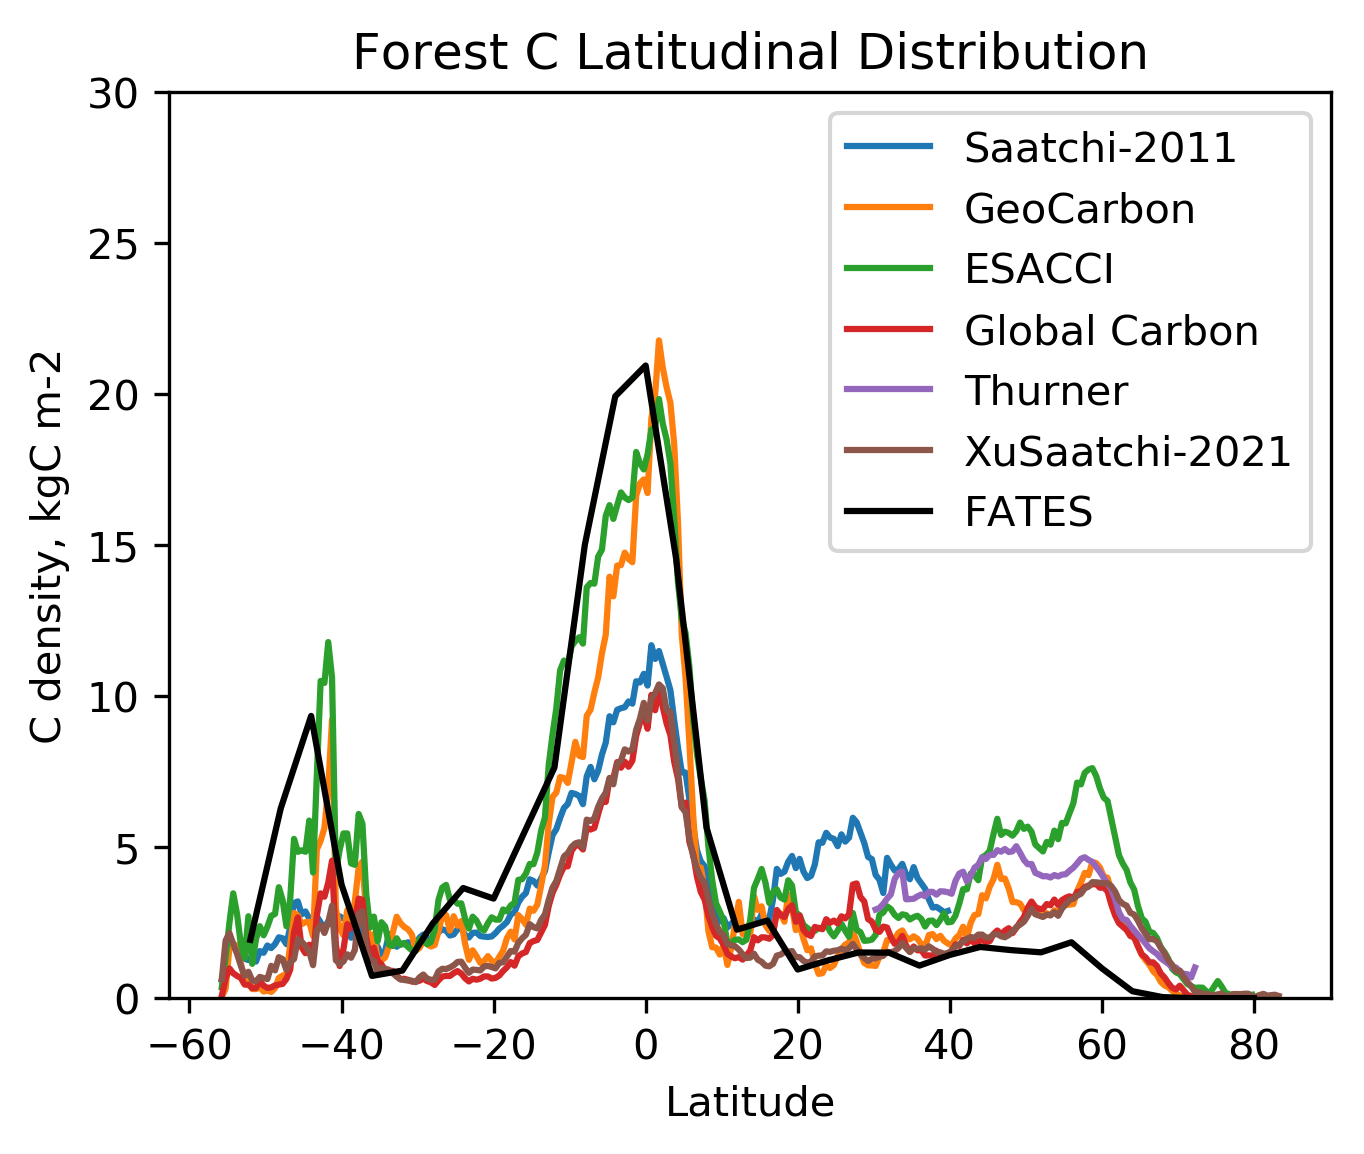

In [8]:
# Biomass C density
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-60.25, 80.25, 0.5)
x3 = np.arange(-92, 92, 4)
x4 = np.arange(89.75, -90.25, -0.5)
x5 = np.arange(83.75, -56.75, -0.5)
plt.plot(x1, tropical_lat)
# Here 0.1 is the transfer factor of the unit: Mg/ha -> kg/m2.
plt.plot(x5, geocarbon_lat*0.1)
plt.plot(x2, esacci_lat*0.1)
plt.plot(x1, gc_lat)
# plt.plot(x1, nbcd2000_lat)
# plt.plot(x1, usf_lat)
plt.plot(x1, thurner_lat)
plt.plot(x4, xusaatchi_lat*0.1) 
plt.plot(x3, vegc_for_lat, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['Saatchi-2011', 'GeoCarbon', 'ESACCI', 'Global Carbon', 'Thurner', 'XuSaatchi-2021', 'FATES'])
plt.title('Forest C Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('C density, kgC m-2')
# plt.yscale('log')
plt.ylim([0, 30])
plt.savefig('BiomassC_den_comparison_obs.png')

In [12]:
# The difference between FATES and observation products for Northern High Latitudes (>45N) 
np.nanmean(vegc_for_lat[39:46]) - np.nanmean(geocarbon_lat[210:281]*0.1)

-2.069023455719124

In [22]:
# Calculate global total of all products
# Tropical - Global tropical forest, Saatchi-2011
# GeoCarbon - GEOCARBON forest biomass, managed vy MPI-Jena
# ESACCI - ESA CCI above-ground biomass product
# Global Carbon - Global forest biomass from JPL, Also from Satchi 2011 paper?
# Thurner 2014 - Martin Thurner, temperate and boreal forest bimass
# Xu & Saatchi, 2021 - 2021

tropical_for_c_copy[tropical_for_c_copy<=0] = np.float('nan')
tropical_global =  np.nansum(np.nansum(tropical_for_c_copy[:,:] * grid_area[:,:], 0), 0) * 1e-12
geocarbon_for_c_copy[geocarbon_for_c_copy<=0] = np.float('nan')
geocarbon_global =  np.nansum(np.nansum(geocarbon_for_c_copy * 0.1 * grid_area[12:293,:], 0), 0) * 1e-12
esacci_for_c_copy[esacci_for_c_copy<=0] = np.float('nan')
esacci_global =  np.nansum(np.nansum(esacci_for_c_copy[:,0:720] * 0.1 * grid_area[59:340,:], 0), 0) * 1e-12
gc_for_c_copy[gc_for_c_copy<=0] = np.float('nan')
gc_global =  np.nansum(np.nansum(gc_for_c_copy[:,:] * grid_area[:,:], 0), 0) * 1e-12
thurner_for_c_copy[thurner_for_c_copy<=0] = np.float('nan')
thurner_global =  np.nansum(np.nansum(thurner_for_c_copy[:,:] * grid_area[:,:], 0), 0) * 1e-12
xusaatchi_for_c_copy[xusaatchi_for_c_copy<=0] = np.float('nan')
xusaatchi_global =  np.nansum(np.nansum(xusaatchi_for_c_copy[:,:] * 0.1 * grid_area[:,:], 0), 0) * 1e-12
vegc_fates_for[vegc_fates_for<=0] = np.float('nan')
vegc_fates_for[vegc_fates_for>1e5] = np.float('nan')
vegc_global = np.nansum(np.nansum(vegc_fates_for[:,:] * area_4x5[:,:] * vegc_for_area[:,:] * fates_area_frac[12*sel_yr-1,:,:] * 1e6, 0), 0) * 1e-12

# # Regional check (Since the result is not so promising, we skip this for now.)
# # Tropical product range from 30 N to 40 S
# vegc_tropical = np.nansum(np.nansum(vegc_fates_for[13:31,:] * area_4x5[13:31,:] * vegc_for_area[13:31,:] * fates_area_frac[12*sel_yr-1,13:31,:] * 1e6, 0), 0) * 1e-12


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encoun

### Albedo

In [144]:
# Open albedo observations
filename_in = 'albedo_data_ilamb/albedoCERESed4.1.nc'
ds = nc4.Dataset(filename_in)
ceres_alb_tmp = ds.variables['albedo'][:]
ceres_alb_time = ds.variables['time'][:]
ds.close()

# There's some issue in the dataset: the western part of data is corrupted.
# Have to abandon this data for now. 
# Need to go back and check with ILAMB team if needed.
ceres_alb = np.nanmean(ceres_alb_tmp[:,:,:], axis=0)

filename_in = 'albedo_data_ilamb/albedo_0.5x0.5_GEWEX.nc'
ds = nc4.Dataset(filename_in)
gewex_alb_tmp = ds.variables['albedo'][:]
gewex_alb_time = ds.variables['time'][:]
ds.close()

# make a tag to determine if we want JJA or annual
do_jja = True

if(do_jja):
    gewex_summer = np.zeros((21,360,720))
    for i in np.arange(17,24):
        gewex_summer[3*(i-17):3*(i-17)+3,:,:] = gewex_alb_tmp[12*i+5:12*i+8,:,:]
    gewex_alb = np.nanmean(gewex_summer[:,:,:], axis=0)
else:
    gewex_all = np.zeros((84,360,720))
    for i in np.arange(17,24):
        gewex_all[12*(i-17):12*(i-17)+12,:,:] = gewex_alb_tmp[12*i:12*i+12,:,:]
    gewex_alb = np.nanmean(gewex_all[:,:,:], axis=0)
        

In [162]:
# Get the latitudinal mean of albedo from FATES
alb_copy = copy.deepcopy(ref_sr[:,:,:]/(tot_sr[:,:,:] + 1e-10))
# Only account for mean value of JJA
if(do_jja):
    alb_all_temp = np.zeros((30,46,72))
    for i in np.arange(151,161):
        alb_all_temp[3*(i-151):3*(i-151)+3,:,:] = alb_copy[12*i+5:12*i+8,:,:]
else:
    alb_all_temp = np.zeros((120,46,72))
    for i in np.arange(151,161):
        alb_all_temp[12*(i-151):12*(i-151)+12,:,:] = alb_copy[12*i:12*i+12,:,:]
    
alb_all = np.nanmean(alb_all_temp[:,:,:], 0)
# mask out ocean and anomalous points
alb_all[alb_all>1.0] = np.float('nan')
alb_all[alb_all<0.0] = np.float('nan')
# FATES
alb_lat = np.nanmean(alb_all, 1)
# # Do not plot the region outside observation's range
# alb_lat[0:10] = np.float('nan')

# Other obs
gewex_alb_copy = copy.deepcopy(gewex_alb)
# mask out ocean and anomalous points
gewex_alb_copy[land_dot5xdot5 < 0.5] = np.float('nan')
gewex_alb_copy[gewex_alb_copy>1.0] = np.float('nan')
gewex_alb_copy[gewex_alb_copy<0.0] = np.float('nan')

gewex_alb_lat = np.nanmean(gewex_alb_copy, 1)


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


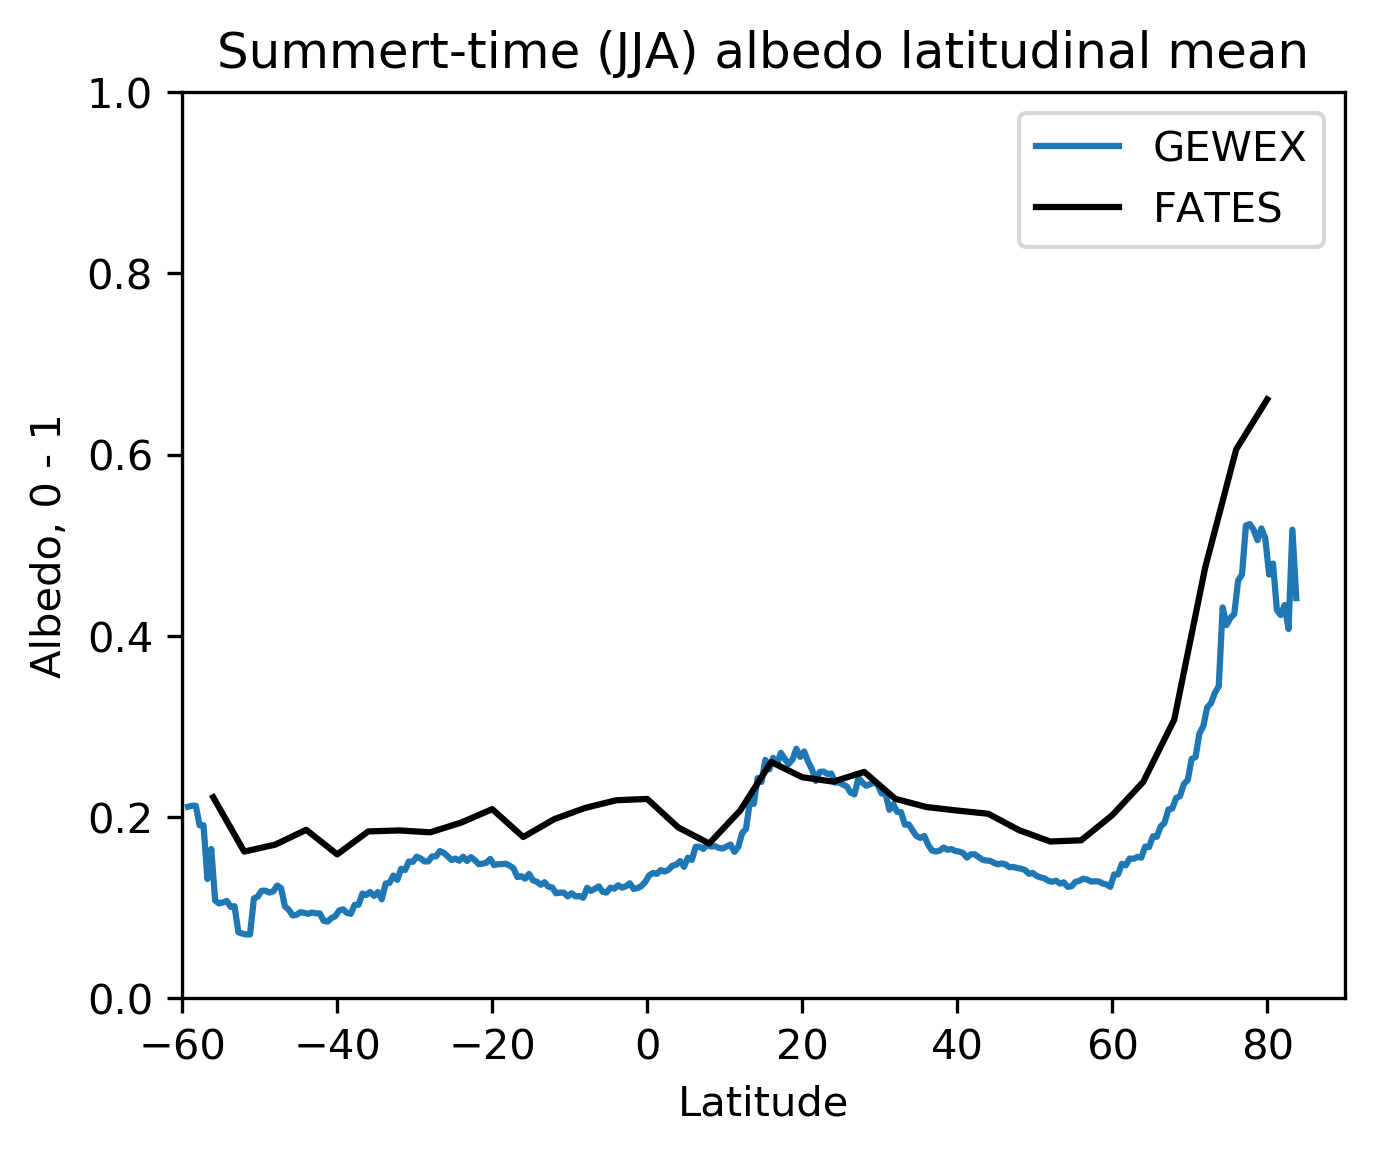

In [163]:
# Albedo
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-92, 92, 4)
x3 = np.arange(89.75, -90.25, -0.5)
plt.plot(x1, gewex_alb_lat)
plt.plot(x2, alb_lat, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['GEWEX', 'FATES'])
plt.title('Summert-time (JJA) albedo latitudinal mean')
plt.xlabel('Latitude')
plt.ylabel('Albedo, 0 - 1')
plt.xlim([-60, 90])
plt.ylim([0, 1])
plt.savefig('Albedo_comparison_obs.png')

In [257]:
# Global mean albedo, area weighted.
# Calculate global mean albedo
# Gewex - GEWEX SRB Radiation observation

gewex_alb_copy[gewex_alb_copy<=0] = np.float('nan')
gewex_alb_global =  np.nansum(np.nansum(gewex_alb_copy[:,:] * land_area[:,:], 0), 0)/np.nansum(land_area[:,:])
alb_all[alb_all<=0] = np.float('nan')
alb_global =  np.nansum(np.nansum(alb_all[:,:]* area_4x5[:,:] * fates_area_frac[12*sel_yr-1,:,:], 0), 0)/np.nansum(area_4x5[:,:] * fates_area_frac[12*sel_yr-1,:,:])


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


### LAI

In [102]:
# Open LAI observations
# make a tag to determine if we want JJA or not
do_jja = False

# AVHRR
filename_in = 'lai_data_ilamb/lai_0.5x0.5_avhrr.nc'
ds = nc4.Dataset(filename_in)
avhrr_lai_tmp = ds.variables['lai'][:]
ds.close()

# JJA, 2001 - 2010
if(do_jja):
    avhrr_lai_temp = np.zeros((30,360,720))
    for i in np.arange(0,10):
        avhrr_lai_temp[3*i:3*i+3,:,:] = avhrr_lai_tmp[12*(i+19)+5:12*(i+19)+8,:,:]
else:
    avhrr_lai_temp = np.zeros((120,360,720))
    for i in np.arange(0,10):
        avhrr_lai_temp[12*i:12*i+12,:,:] = avhrr_lai_tmp[12*(i+19):12*(i+19)+12,:,:]
    
avhrr_lai_temp[avhrr_lai_temp<0] = np.float('nan')
avhrr_lai_temp[avhrr_lai_temp>20.0] = np.float('nan')
avhrr_lai = np.nanmean(avhrr_lai_temp[:,:,:], axis=0)

# MODIS
filename_in = 'lai_data_ilamb/lai_0.5x0.5_modis.nc'
ds = nc4.Dataset(filename_in)
modis_lai_tmp = ds.variables['lai'][:]
ds.close()

# JJA, 2001 - 2010
if(do_jja):
    modis_lai_temp = np.zeros((18,360,720))
    for i in np.arange(0,6):
        modis_lai_temp[3*i:3*i+3,:,:] = modis_lai_tmp[12*i+5:12*i+8,:,:]
else:
    modis_lai_temp = np.zeros((72,360,720))
    for i in np.arange(0,6):
        modis_lai_temp[12*i:12*i+12,:,:] = modis_lai_tmp[12*i:12*i+12,:,:]    

modis_lai_temp[modis_lai_temp<0] = np.float('nan')
modis_lai_temp[modis_lai_temp>20.0] = np.float('nan')
modis_lai = np.nanmean(modis_lai_temp[:,:,:], axis=0)

# AVHRR15C1
filename_in = 'lai_data_ilamb/lai_avh15c1.nc'
ds = nc4.Dataset(filename_in)
avh15c1_lai_tmp = ds.variables['lai'][:]
avh15c1_time = ds.variables['time'][:]
ds.close()

# JJA, 2001 - 2010
if(do_jja):
    avh15c1_lai_temp = np.zeros((30,360,720))
    for i in np.arange(0,10):
        avh15c1_lai_temp[3*i:3*i+3,:,:] = avh15c1_lai_tmp[12*(i+19)+5:12*(i+19)+8,:,:]
else:
    avh15c1_lai_temp = np.zeros((120,360,720))
    for i in np.arange(0,10):
        avh15c1_lai_temp[12*i:12*i+12,:,:] = avh15c1_lai_tmp[12*(i+19):12*(i+19)+12,:,:]

avh15c1_lai_temp[avh15c1_lai_temp<0] = np.float('nan')
avh15c1_lai_temp[avh15c1_lai_temp>20.0] = np.float('nan')
avh15c1_lai = np.nanmean(avh15c1_lai_temp[:,:,:], axis=0)


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


In [244]:
sel_yr = 151

# Get the latitudinal mean of albedo from all datasets
lai_copy = copy.deepcopy(tlai[:,:,:])
if(do_jja):
    lai_all_temp = np.zeros((30,46,72))
    for i in np.arange(151,161):
        lai_all_temp[3*(i-151):3*(i-151)+3,:,:] = lai_copy[12*i+5:12*i+8,:,:]
else:
    lai_all_temp = np.zeros((120,46,72))
    for i in np.arange(151,161):
        lai_all_temp[12*(i-151):12*(i-151)+12,:,:] = lai_copy[12*i:12*i+12,:,:]
    
lai_all_temp[lai_all_temp>20.0] = np.float('nan')
lai_all = np.nanmean(lai_all_temp[:,:,:], 0)
# FATES
lai_lat = np.nanmean(lai_all, 1)
## Do not plot the region outside observation's range
#alb_lat[0:10] = np.float('nan')

# Other obs
avhrr_lai_copy = copy.deepcopy(avhrr_lai)
# Fill all missing grids within the land mask
avhrr_lai_copy[np.isnan(avhrr_lai_copy)] = 0.0
avhrr_lai_copy[np.isnan(land_area)] = np.float('nan')
avhrr_lai_lat = np.nanmean(avhrr_lai_copy, 1)
avhrr_lai_lat[avhrr_lai_lat<=0] = np.float('nan')

modis_lai_copy = copy.deepcopy(modis_lai)
modis_lai_lat = np.nanmean(modis_lai_copy, 1)
modis_lai_lat[modis_lai_lat<=0] = np.float('nan')

avh15c1_lai_copy = copy.deepcopy(avh15c1_lai)
avh15c1_lai_lat = np.nanmean(avh15c1_lai_copy, 1)
avh15c1_lai_lat[avhrr_lai_lat<=0] = np.float('nan')


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less_equal


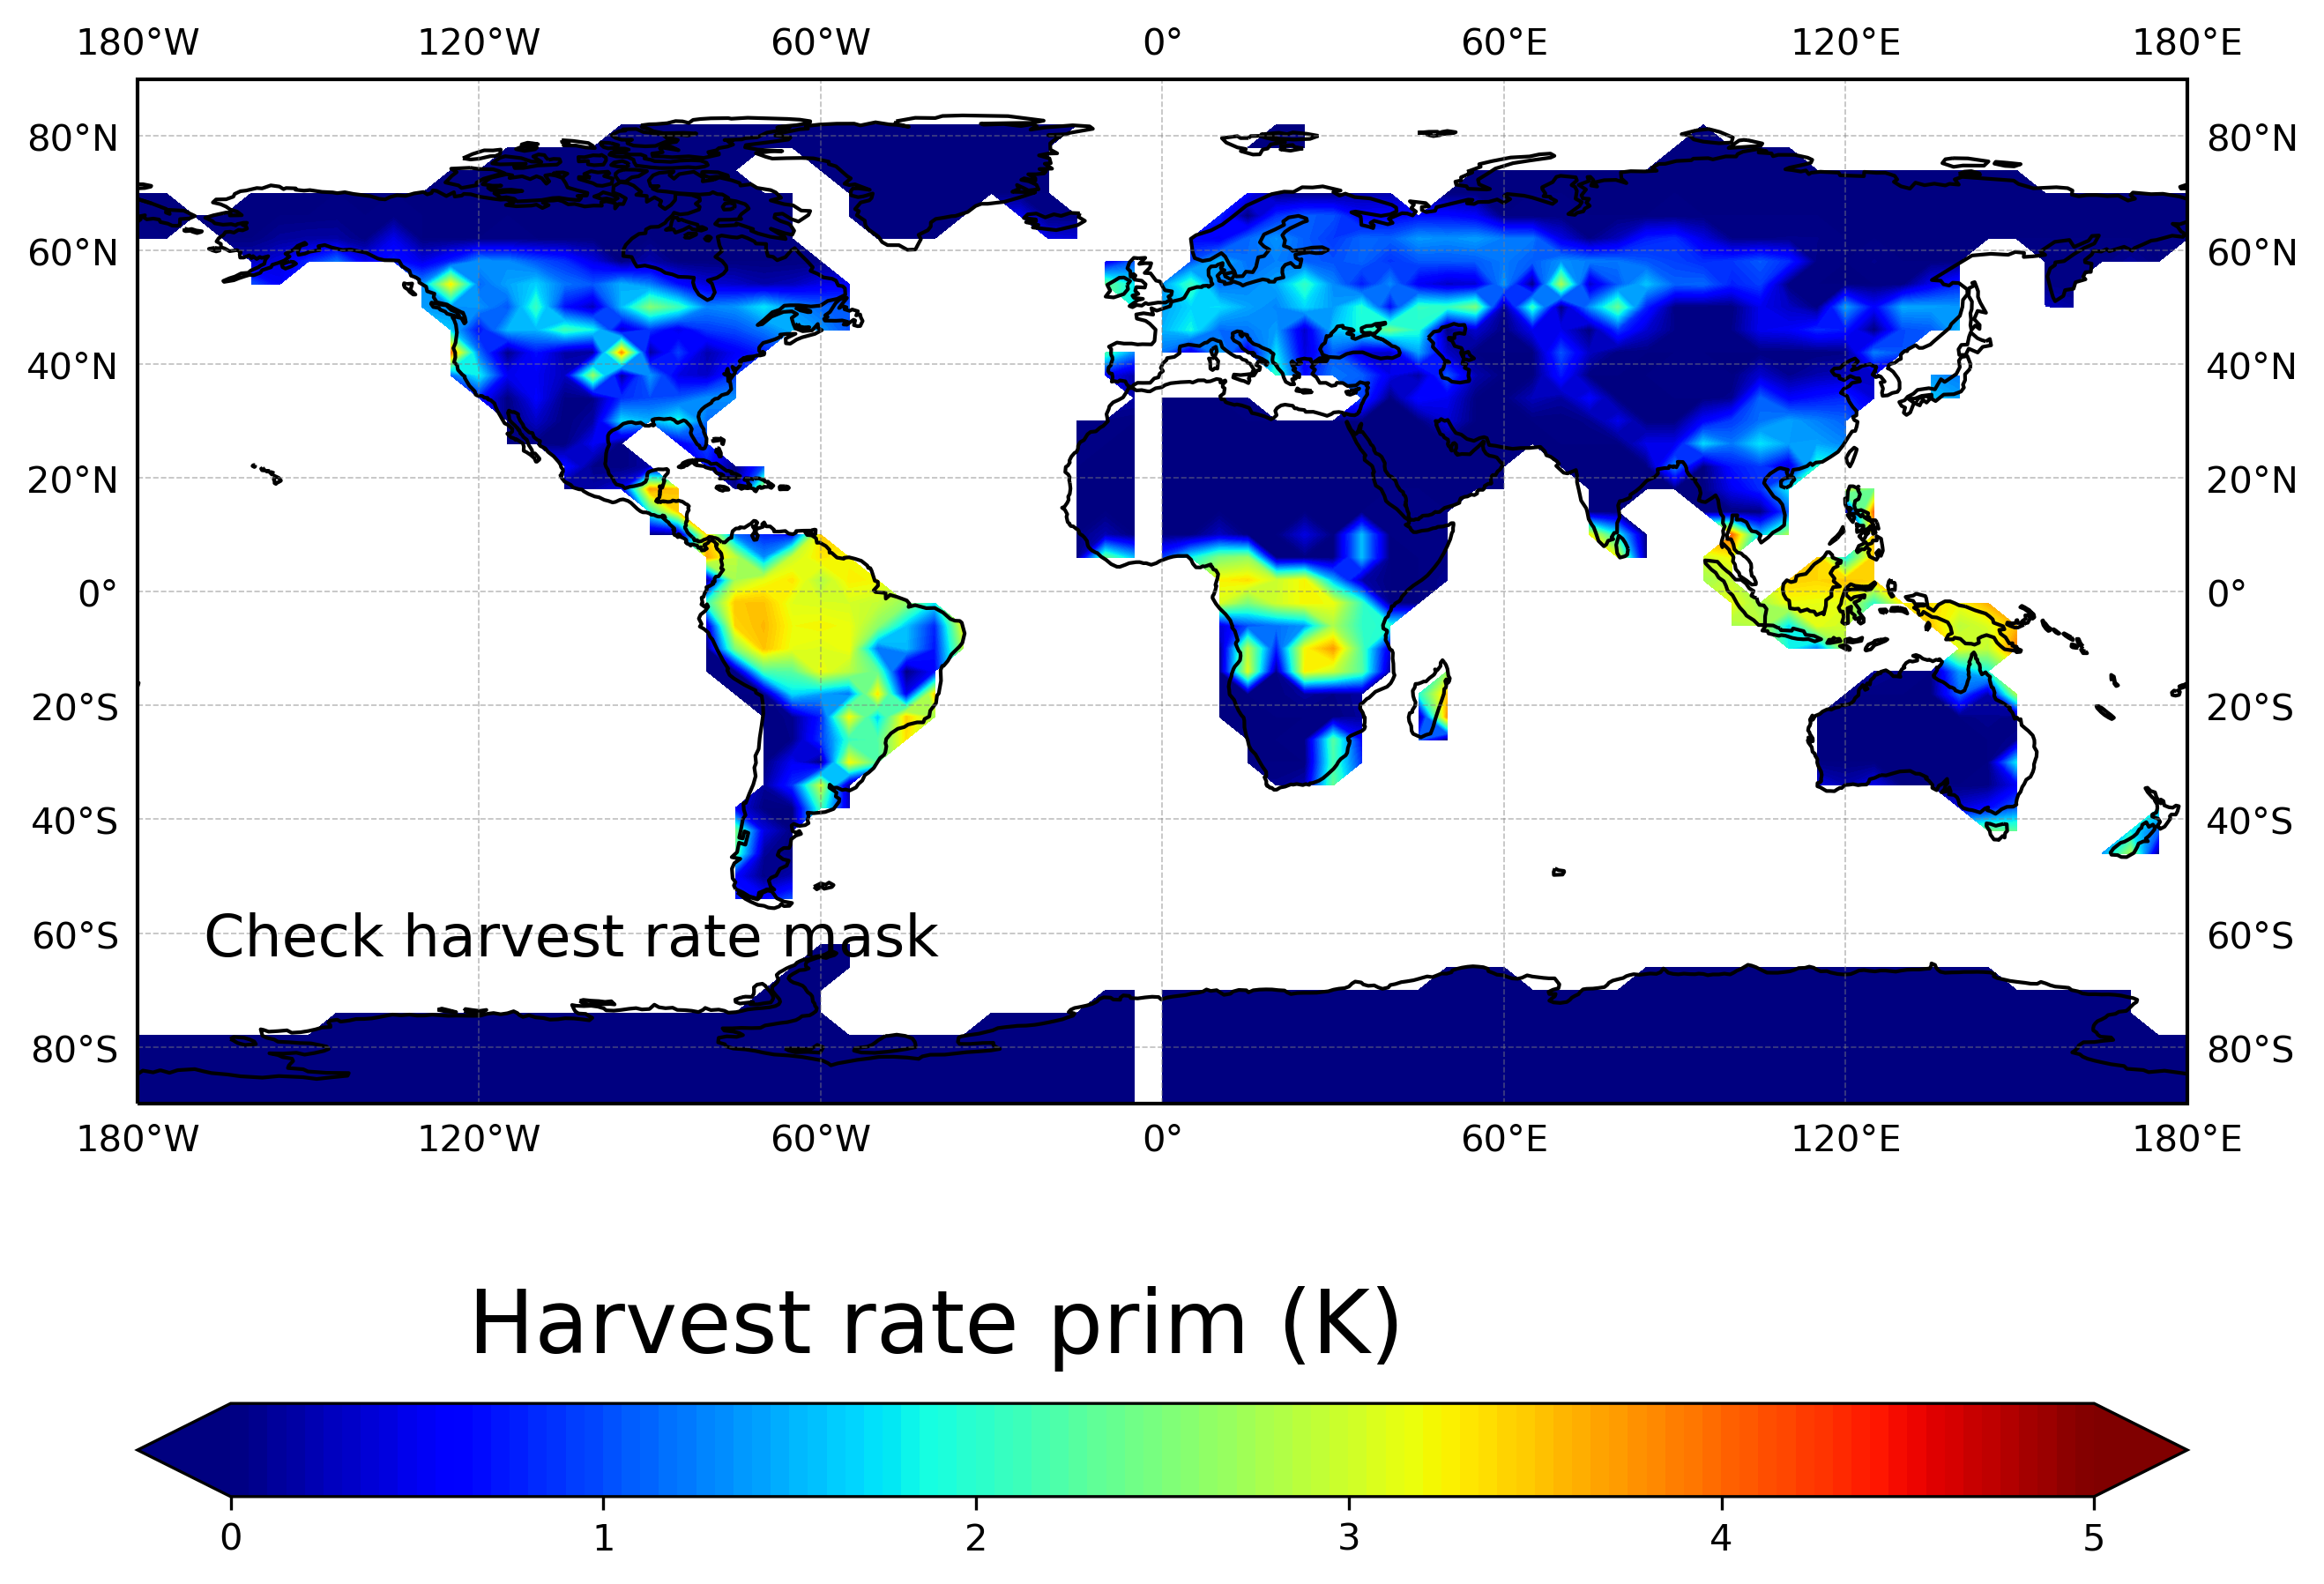

In [114]:
if(verbose):
    # Validate if the mask is working properly
    # make plot
    fig = plt.figure(figsize=(10,10), dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = plt.contourf(lonnc, latnc, lai_all_temp[12,:,:], 60, levels=np.linspace(0, 5.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.text(0.15, 0.37, 'Check LAI', fontsize=16)
    fig.text(0.25, 0.22, 'LAI (m2 m-2)', fontsize=24)
    cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks = [0, 1.0, 2.0, 3.0, 4.0, 5.0] )
    plt.show()

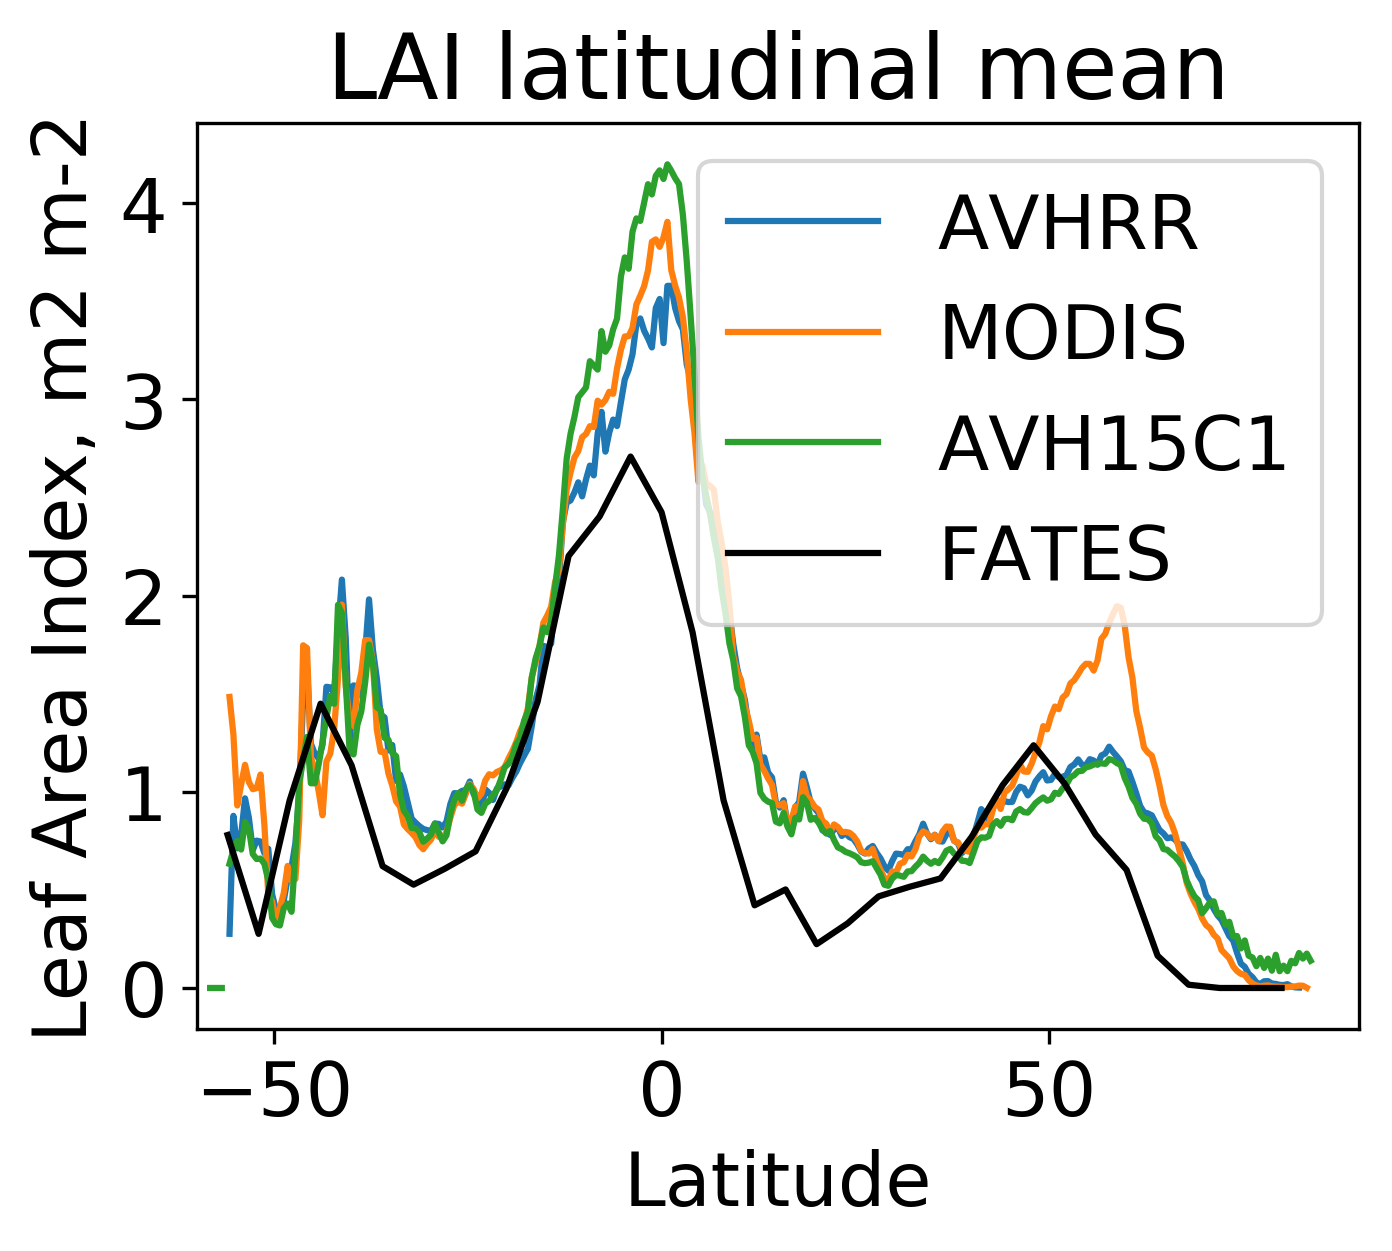

In [245]:
# LAI
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-92, 92, 4)
plt.plot(x1, avhrr_lai_lat)
plt.plot(x1, modis_lai_lat)
plt.plot(x1, avh15c1_lai_lat)
plt.plot(x2, lai_lat, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['AVHRR', 'MODIS', 'AVH15C1', 'FATES'])
plt.title('LAI latitudinal mean')
plt.xlabel('Latitude')
plt.ylabel('Leaf Area Index, m2 m-2')
plt.xlim([-60, 90])
# plt.ylim([0, 1])
plt.savefig('LAI_comparison_obs.png')

In [246]:
# Global mean of LAI.
# Calculate global total of GPP
# AVHRR - Derived from half monthly AVHRR BU leaf area index from Boston University
# MODIS - MODIS Climatology Leaf Area Index (LAI) from NCAR
# AVH15c1 - Daily gridded Leaf Area Index (LAI) derived from the NOAA Climate Data Record
nlon = 360
nlat = 180
grid_area_1d = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-89.5, 90.5, 1.0)
res = 1.0;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area_1d[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

avhrr_lai_copy[avhrr_lai_copy<=0] = np.float('nan')
avhrr_lai_global =  np.nansum(np.nansum(avhrr_lai_copy[:,:]*land_area[:,:], 0), 0)/np.nansum(land_area[:,:])
modis_lai_copy[modis_lai_copy<=0] = np.float('nan')
modis_lai_global = np.nansum(np.nansum(modis_lai_copy[:,:]*land_area[:,:], 0), 0)/np.nansum(land_area[:,:])
avh15c1_lai_copy[avh15c1_lai_copy<=0] = np.float('nan')
avh15c1_lai_global = np.nansum(np.nansum(avh15c1_lai_copy[:,:]*land_area[:,:], 0), 0)/np.nansum(land_area[:,:])
lai_all[lai_all<=0] = np.float('nan')
lai_global = np.nansum(np.nansum(lai_all[:,:]*area_4x5[:,:]*fates_area_frac[12*sel_yr-1,:,:], 0), 0)/np.nansum(area_4x5[:,:]*fates_area_frac[12*sel_yr-1,:,:])



C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less_equal


### GPP

In [14]:
# Open GPP observations
filename_in = 'gpp_data_ilamb/gpp_fluxcom.nc'
ds = nc4.Dataset(filename_in)
fluxcom_gpp_tmp = ds.variables['gpp'][:]
ds.close()

fluxcom_gpp = np.nanmean(fluxcom_gpp_tmp[:,:], axis=0)

filename_in = 'gpp_data_ilamb/gpp_fluxnet2015.nc'
ds = nc4.Dataset(filename_in)
fluxnet2015_gpp_tmp = ds.variables['gpp'][:]
ds.close()

fluxnet2015_gpp = copy.deepcopy(fluxnet2015_gpp_tmp[:,:])

filename_in = 'gpp_data_ilamb/gpp_wecann.nc'
ds = nc4.Dataset(filename_in)
wecann_gpp_tmp = ds.variables['gpp'][:]
ds.close()

wecann_gpp = np.nanmean(wecann_gpp_tmp[:,:,:], axis=0)

In [254]:
sel_yr = 160

# Get the latitudinal mean of albedo from all datasets
gpp_copy = copy.deepcopy(gpp[:,:,:])
# gpp_all_temp = np.zeros((72,46,72))
# for i in np.arange(140,164):
#     lai_all_temp[3*(i-140):3*(i-140)+3,:,:] = lai_copy[12*i+5:12*i+8,:,:]
# gpp_all_temp[lai_all_temp>20.0] = np.float('nan')
gpp_all = np.nanmean(gpp_copy[sel_yr*12:sel_yr*12+12,:,:], 0)
# FATES
gpp_lat = np.nanmean(gpp_all, 1)
## Do not plot the region outside observation's range
#alb_lat[0:10] = np.float('nan')

# Other obs
fluxcom_gpp_copy = copy.deepcopy(fluxcom_gpp)
# Fill all missing grids within the land mask
fluxcom_gpp_copy[np.isnan(fluxcom_gpp_copy)] = 0.0
fluxcom_gpp_copy[np.isnan(land_area[::-1,:])] = np.float('nan')
fluxcom_gpp_lat = np.nanmean(fluxcom_gpp_copy, 1)
# fluxcom_gpp_lat[fluxcom_gpp_lat<=0] = np.float('nan')

# There's some problem with this dataset
fluxnet2015_gpp_copy = copy.deepcopy(fluxnet2015_gpp)
fluxnet2015_gpp_lat = np.nanmean(fluxnet2015_gpp_copy, 1)
fluxnet2015_gpp_lat[fluxnet2015_gpp_lat<=0] = np.float('nan')

wecann_gpp_copy = copy.deepcopy(wecann_gpp)
wecann_gpp_lat = np.nanmean(wecann_gpp_copy, 1)
wecann_gpp_lat[wecann_gpp_lat<=0] = np.float('nan')


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal


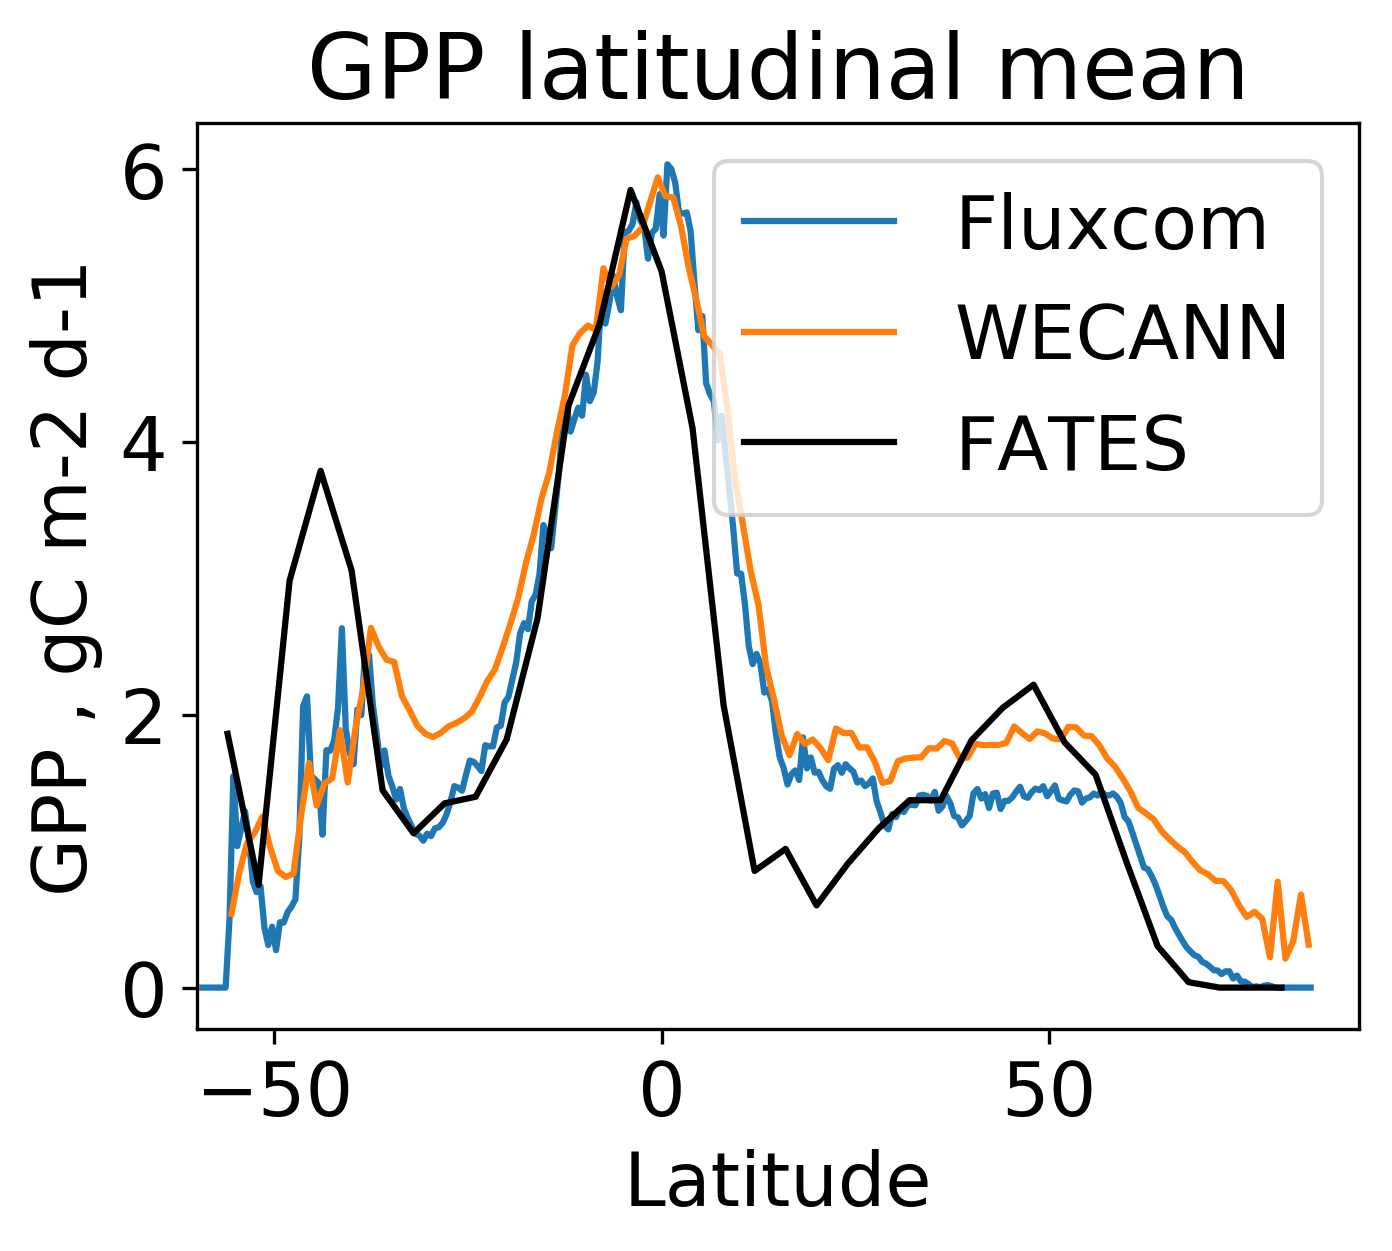

In [256]:
# GPP
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-63.75, 80.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
plt.plot(x1, fluxcom_gpp_lat)
# plt.plot(x3, fluxnet2015_gpp_lat)
plt.plot(x4, wecann_gpp_lat)
plt.plot(x2, gpp_lat*1000.0*3600.0*24.0, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['Fluxcom', 'WECANN', 'FATES'])
plt.title('GPP latitudinal mean')
plt.xlabel('Latitude')
plt.ylabel('GPP , gC m-2 d-1')
plt.xlim([-60, 90])
# plt.ylim([0, 1])
plt.savefig('GPP_comparison_obs.png')

In [48]:
# Calculate global total of GPP
# Fluxcom - Jung, 2017
# Wecann - Water, Energy, and Carbon with Artificial Neural Networks (WECANN), Alemohammad et al., 2017
# Global grid area for 1.0 deg 
nlon = 360
nlat = 180
grid_area_1d = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-89.5, 90.5, 1.0)
res = 1.0;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area_1d[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

fluxcom_gpp_copy[fluxcom_gpp_copy<=0] = np.float('nan')
fluxcom_gpp_global =  np.nansum(np.nansum(fluxcom_gpp_copy[:,:] * 365* grid_area[:,:], 0), 0) * 1e-15
wecann_gpp_copy[wecann_gpp_copy<=0] = np.float('nan')
wecann_gpp_global =  np.nansum(np.nansum(wecann_gpp_copy[:,:] * 365* grid_area_1d[:,:], 0), 0) * 1e-15
gpp_all[gpp_all<=0] = np.float('nan')
gpp_global =  np.nansum(np.nansum(gpp_all[:,:] *3600.0*24.0*365 * area_4x5[:,:]*1e6 * fates_area_frac[12*sel_yr-1,:,:], 0), 0) * 1e-12


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


### SHF

In [166]:
# Open Sh observations
filename_in = 'sh_data_ilamb/hfss_class.nc'
ds = nc4.Dataset(filename_in)
class_hfss_tmp = ds.variables['hfss'][:]
ds.close()

class_hfss = np.nanmean(class_hfss_tmp[:,:,:], axis=0)

filename_in = 'sh_data_ilamb/hfss_fluxcom.nc'
ds = nc4.Dataset(filename_in)
fluxcom_hfss_tmp = ds.variables['sh'][:]
ds.close()

fluxcom_hfss = np.nanmean(fluxcom_hfss_tmp[:,:,:], axis=0)

# Site level data
filename_in = 'sh_data_ilamb/hfss_fluxnet2015.nc'
ds = nc4.Dataset(filename_in)
fluxnet2015_hfss_tmp = ds.variables['hfss'][:]
ds.close()

fluxnet2015_hfss = copy.deepcopy(fluxnet2015_hfss_tmp[:,:])

filename_in = 'sh_data_ilamb/hfss_wecann.nc'
ds = nc4.Dataset(filename_in)
wecann_hfss_tmp = ds.variables['hfss'][:]
ds.close()

wecann_hfss = np.nanmean(wecann_hfss_tmp[:,:,:], axis=0)

In [167]:
sel_yr = 151

# Get the latitudinal mean of SHF from all datasets
hfss_copy = copy.deepcopy(tot_sh[:,:,:])
hfss_all = np.nanmean(hfss_copy[12*sel_yr:12*(sel_yr+10),:,:], 0)
# FATES
hfss_lat = np.nanmean(hfss_all, 1)
## Do not plot the region outside observation's range
#alb_lat[0:10] = np.float('nan')

# Other obs
class_hfss_copy = copy.deepcopy(class_hfss)
class_hfss_lat = np.nanmean(class_hfss_copy, 1)
# class_hfss_lat[class_hfss_lat<=0] = np.float('nan')

fluxcom_hfss_copy = copy.deepcopy(fluxcom_hfss)
fluxcom_hfss_lat = np.nanmean(fluxcom_hfss_copy, 1)
# fluxcom_hfss_lat[fluxcom_hfss_lat<=0] = np.float('nan')

# There's some problem with this dataset
fluxnet2015_hfss_copy = copy.deepcopy(fluxnet2015_hfss)
fluxnet2015_hfss_lat = np.nanmean(fluxnet2015_hfss_copy, 1)
# fluxnet2015_hfss_lat[fluxnet2015_hfss_lat<=0] = np.float('nan')

wecann_hfss_copy = copy.deepcopy(wecann_hfss)
wecann_hfss_lat = np.nanmean(wecann_hfss_copy, 1)
# wecann_hfss_lat[wecann_hfss_lat<=0] = np.float('nan')

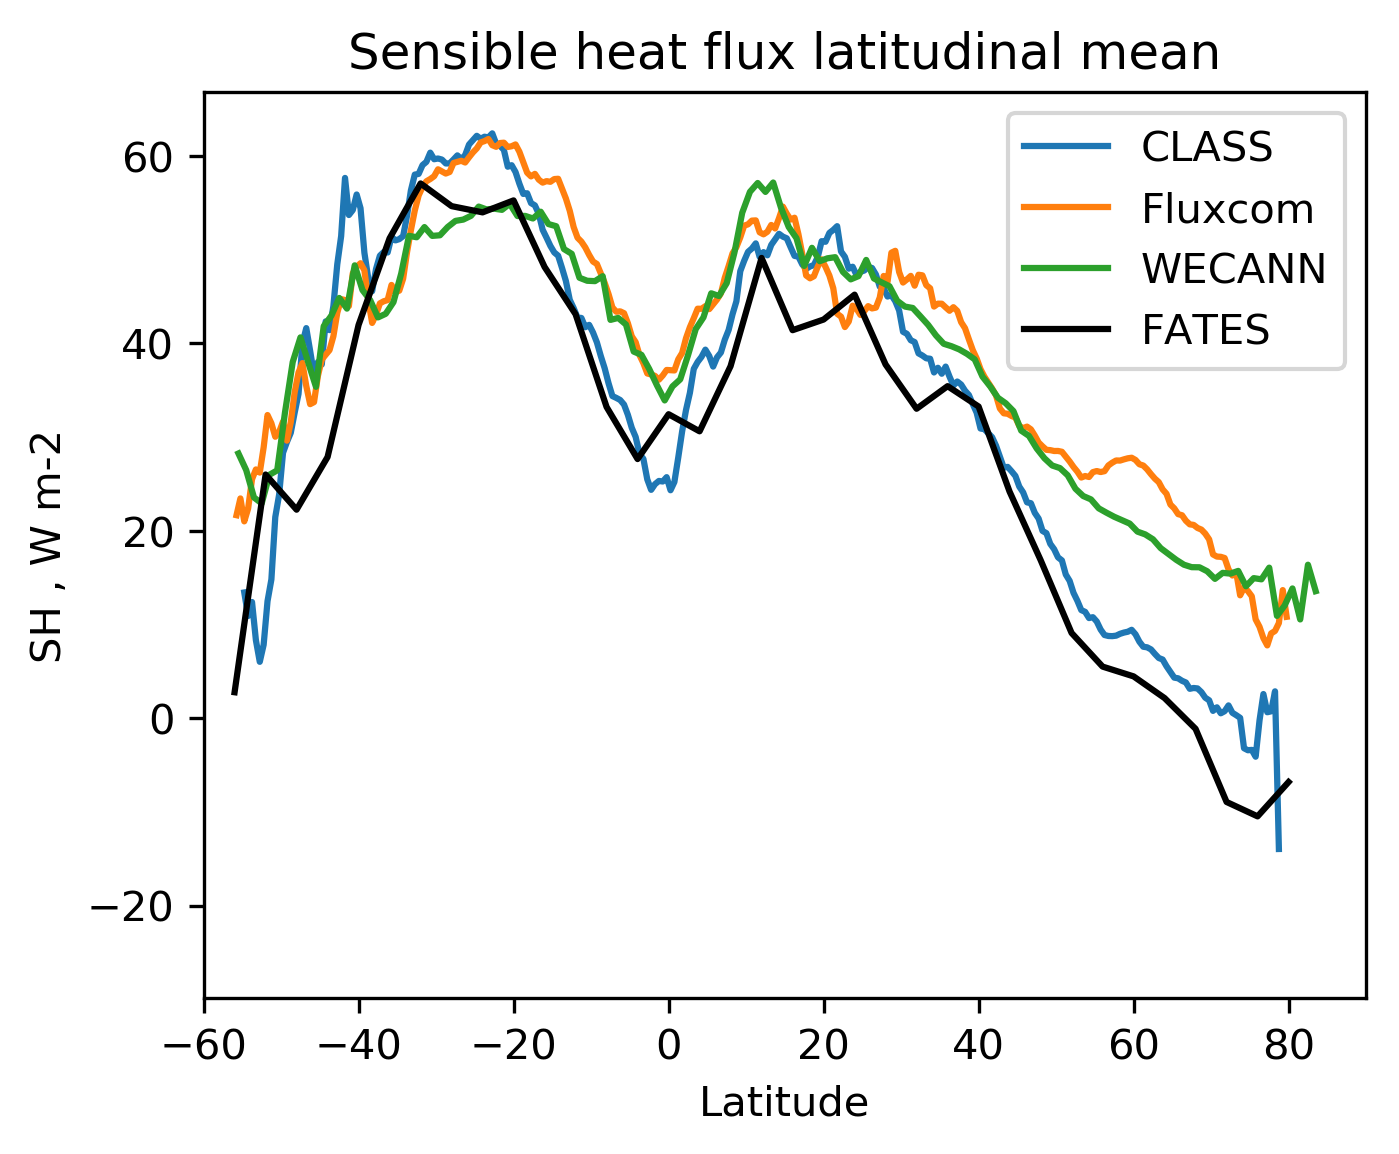

In [217]:
# SH
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-89.75, 90.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
plt.plot(x3, class_hfss_lat)
plt.plot(x3, fluxcom_hfss_lat)
# plt.plot(x3, fluxnet2015_gpp_lat)
plt.plot(x4, wecann_hfss_lat)
plt.plot(x2, hfss_lat, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['CLASS', 'Fluxcom', 'WECANN', 'FATES'])
plt.title('Sensible heat flux latitudinal mean')
plt.xlabel('Latitude')
plt.ylabel('SH , W m-2')
plt.xlim([-60, 90])
# plt.ylim([0, 1])
plt.savefig('SH_comparison_obs.png')

In [187]:
# Calculate global mean of SHF
# hfss_class - Conserving Land–Atmosphere Synthesis Suite (CLASS) SHF product, Hobeichi et al., 2020
# hfss_fluxcom - ML-based global products upscaled from fluxnet sites, Jung et al., 2019
# hfss_fluxnet2015 - Fluxnet site level measurement compiled in 2015
# hfss_wecann - Energy flux products retrieved from SIF measurements and upscaled  through ML-based approach, Alemohammad et al., 2017

class_hfss_copy[class_hfss_copy<=0] = np.float('nan')
class_hfss_global = np.nansum(np.nansum(class_hfss_copy[:,:] * land_area[:,:], 0), 0)/np.nansum(land_area[:,:])
fluxcom_hfss_copy[fluxcom_hfss_copy<=0] = np.float('nan')
fluxcom_hfss_global = np.nansum(np.nansum(fluxcom_hfss_copy[:,:] * land_area[:,:], 0), 0)/np.nansum(land_area[:,:])
wecann_hfss_copy[wecann_hfss_copy<=0] = np.float('nan')
wecann_hfss_global = np.nansum(np.nansum(wecann_hfss_copy[:,:] * land_area_1d[::-1,:], 0), 0)/np.nansum(land_area_1d[::-1,:])
hfss_all[hfss_all<=0] = np.float('nan')
hfss_global = np.nansum(np.nansum(hfss_all[:,:] * area_4x5[:,:] * fates_area_frac[12*sel_yr-1,:,:], 0), 0)/np.nansum(area_4x5[:,:] * fates_area_frac[12*sel_yr-1,:,:])


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]


### ET

In [294]:
# Open ET observations
filename_in = 'et_data_ilamb/et_0.5x0.5_modis.nc'
ds = nc4.Dataset(filename_in)
modis_et_tmp = ds.variables['et'][:]
modis_et_time = ds.variables['time'][:]
ds.close()

modis_et = np.nanmean(modis_et_tmp[12*1:12*11,:,:], axis=0)

filename_in = 'et_data_ilamb/et_gleamv3.3a.nc'
ds = nc4.Dataset(filename_in)
gleam_et_tmp = ds.variables['et'][:]
gleam_et_time = ds.variables['time'][:]
ds.close()

gleam_et = np.nanmean(gleam_et_tmp[12*21:12*31,:,:], axis=0)

# Site level data
filename_in = 'et_data_ilamb/et_mod16A2.nc'
ds = nc4.Dataset(filename_in)
mod16a2_et_tmp = ds.variables['et'][:]
mod16a2_et_time = ds.variables['time'][:]
ds.close()

mod16a2_et = np.nanmean(mod16a2_et_tmp[12*1:12*11,:,:], axis=0)


In [295]:
sel_yr = 151

# Get the latitudinal mean from all datasets
et_copy = copy.deepcopy(et[:,:,:])
et_all = np.nanmean(et_copy[12*sel_yr:12*(sel_yr+10),:,:], 0)
# FATES
et_lat = np.nanmean(et_all, 1)
## Do not plot the region outside observation's range
#alb_lat[0:10] = np.float('nan')

# Other obs
modis_et_copy = copy.deepcopy(modis_et)
# Fill all missing grids within the land mask
modis_et_copy[np.isnan(modis_et_copy)] = 0.0
modis_et_copy[np.isnan(land_area)] = np.float('nan')
modis_et_lat = np.nanmean(modis_et_copy, 1)
# class_hfss_lat[class_hfss_lat<=0] = np.float('nan')

gleam_et_copy = copy.deepcopy(gleam_et)
gleam_et_lat = np.nanmean(gleam_et_copy, 1)
# fluxcom_hfss_lat[fluxcom_hfss_lat<=0] = np.float('nan')

# There's some problem with this dataset
mod16a2_et_copy = copy.deepcopy(mod16a2_et)
mod16a2_et_lat = np.nanmean(mod16a2_et_copy, 1)
# fluxnet2015_hfss_lat[fluxnet2015_hfss_lat<=0] = np.float('nan')



C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


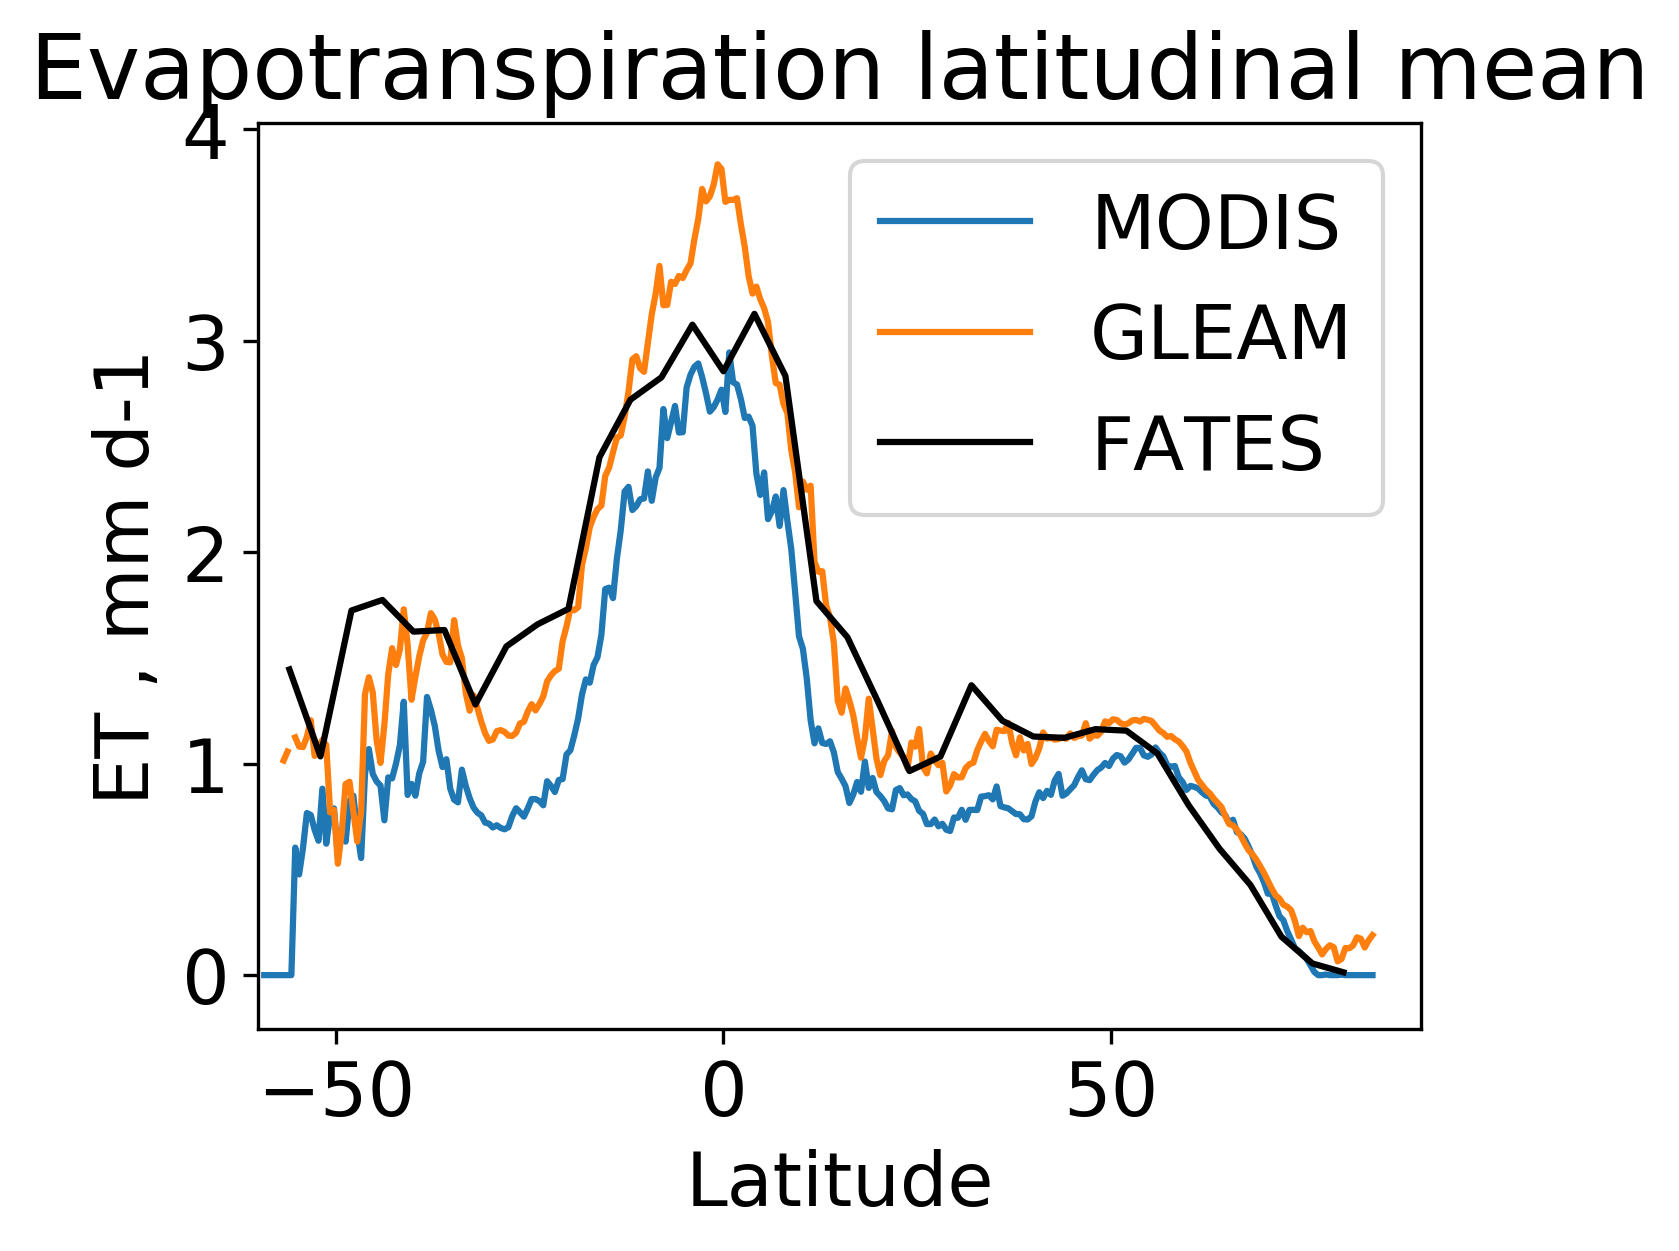

In [296]:
# ET
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-89.75, 90.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
plt.plot(x3, modis_et_lat*3600*24.0)
plt.plot(x3, gleam_et_lat*3600*24.0)
# plt.plot(x1, mod16a2_et_lat*3600*24.0)
plt.plot(x2, et_lat*3600*24.0, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['MODIS', 'GLEAM', 'FATES'])
plt.title('Evapotranspiration latitudinal mean')
plt.xlabel('Latitude')
plt.ylabel('ET , mm d-1')
plt.xlim([-60, 90])
# plt.ylim([0, 1])
plt.savefig('ET_comparison_obs.png')

In [309]:
# Calculate global mean of ET
# et MODIS - MOD16A2 ET product
# et gleam - Global Land Evaporation Amsterdam Model products with satellite observation

modis_et_copy[modis_et_copy<=0] = np.float('nan')
modis_et_global = np.nansum(np.nansum(modis_et_copy[:,:] * land_area[:,:], 0), 0)/np.nansum(land_area[:,:])*3600*24.0*365
gleam_et_copy[gleam_et_copy<=0] = np.float('nan')
gleam_et_global = np.nansum(np.nansum(gleam_et_copy[:,:] * land_area[:,:], 0), 0)/np.nansum(land_area[:,:])*3600*24.0*365
et_all[et_all<=0] = np.float('nan')
et_global = np.nansum(np.nansum(et_all[:,:] * area_4x5[:,:] * fates_area_frac[12*sel_yr-1,:,:] * land_4x5[:,:], 0), 0)/np.nansum(area_4x5[:,:] * fates_area_frac[12*sel_yr-1,:,:] * land_4x5[:,:])*3600*24.0*365


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


## Combined figure

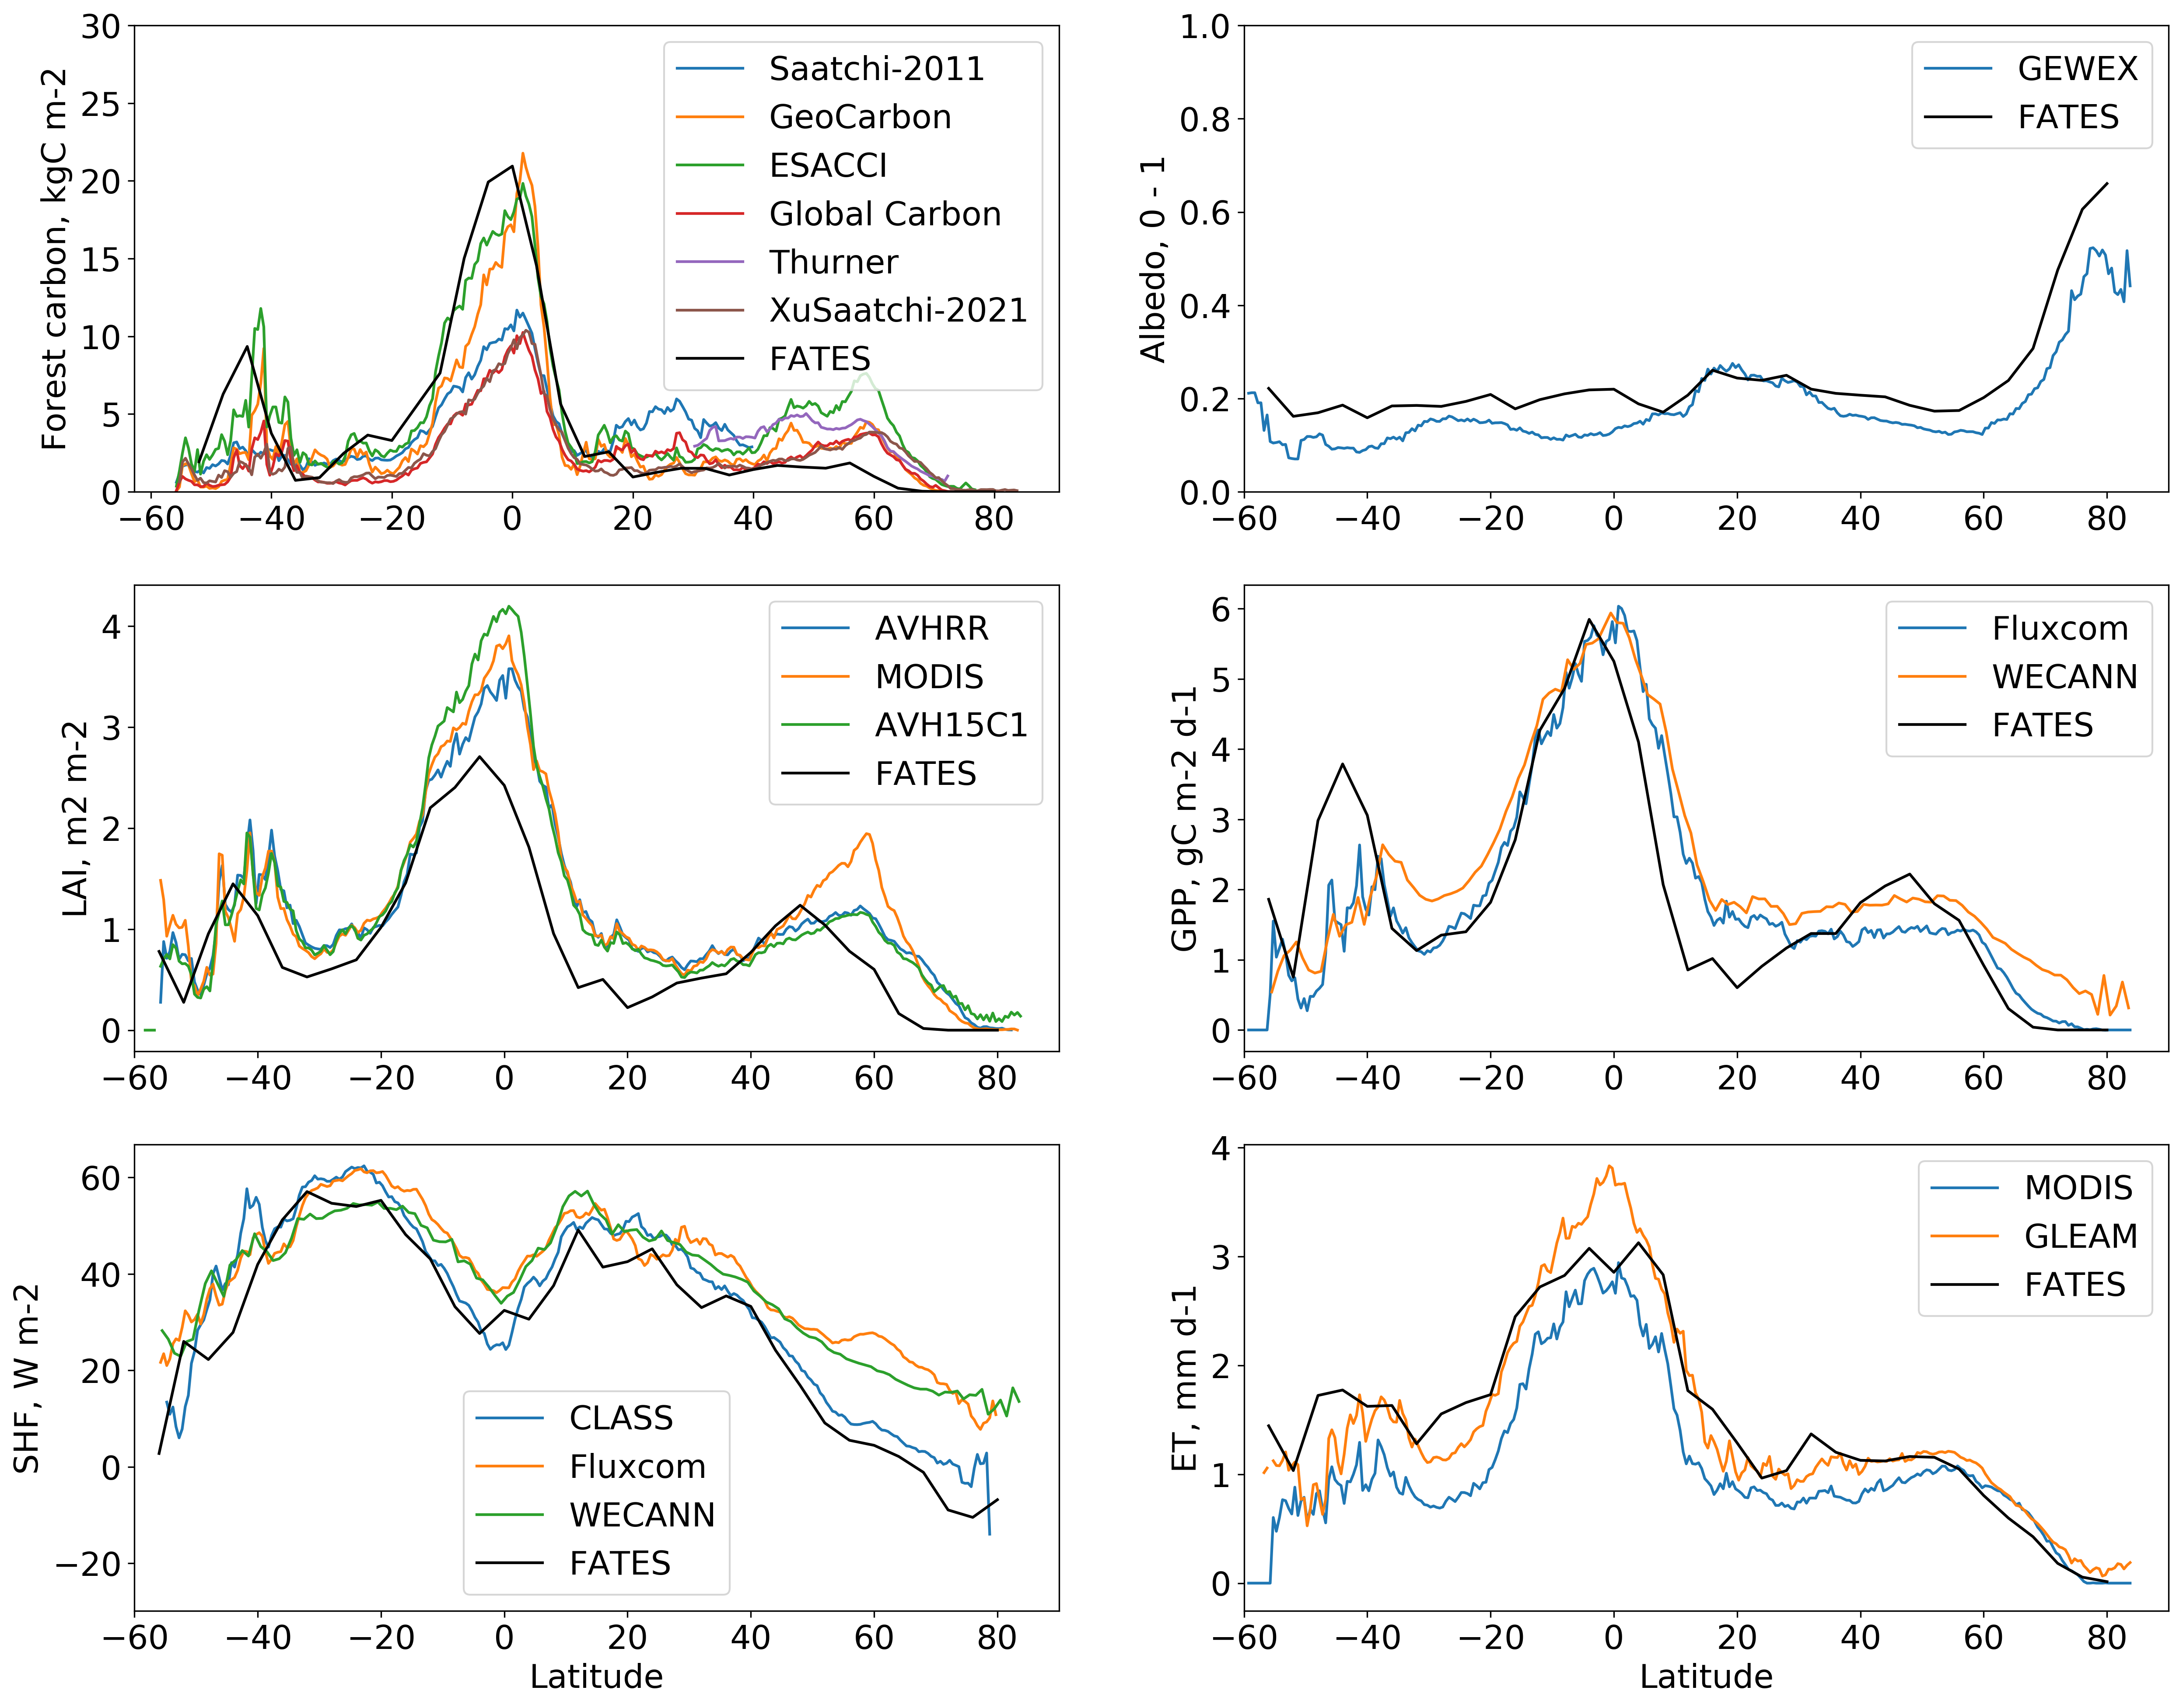

In [304]:
fig = plt.figure(figsize=(20,16), dpi=300)

plt.rcParams.update({'font.size': 18})

ax1 = fig.add_subplot(321)
# Biomass C density
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-60.25, 80.25, 0.5)
x3 = np.arange(-92, 92, 4)
x4 = np.arange(90.25, -89.75, -0.5)
x5 = np.arange(83.75, -56.75, -0.5)
ax1.plot(x1, tropical_lat)
# Here 0.1 is the transfer factor of the unit: Mg/ha -> kg/m2.
ax1.plot(x5, geocarbon_lat*0.1)
ax1.plot(x2, esacci_lat*0.1)
ax1.plot(x1, gc_lat)
ax1.plot(x1, thurner_lat)
ax1.plot(x4, xusaatchi_lat*0.1)
ax1.plot(x3, vegc_for_lat, 'k-')
ax1.legend(['Saatchi-2011', 'GeoCarbon', 'ESACCI', 'Global Carbon', 'Thurner', 'XuSaatchi-2021', 'FATES'])
# ax1.set_title('Forest carbon')
# ax1.set_xlabel('Latitude')
ax1.set_ylabel('Forest carbon, kgC m-2')
# plt.yscale('log')
ax1.set_ylim([0, 30])

# Albedo
ax2 = fig.add_subplot(322)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-92, 92, 4)
x3 = np.arange(89.75, -90.25, -0.5)
ax2.plot(x1, gewex_alb_lat)
ax2.plot(x2, alb_lat, 'k-')
ax2.legend(['GEWEX', 'FATES'])
# ax2.set_title('Summert-time (JJA) albedo')
# ax2.set_xlabel('Latitude')
ax2.set_ylabel('Albedo, 0 - 1')
ax2.set_xlim([-60, 90])
ax2.set_ylim([0, 1])

# LAI
ax3 = fig.add_subplot(323)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-92, 92, 4)
ax3.plot(x1, avhrr_lai_lat)
ax3.plot(x1, modis_lai_lat)
ax3.plot(x1, avh15c1_lai_lat)
ax3.plot(x2, lai_lat, 'k-')
ax3.legend(['AVHRR', 'MODIS', 'AVH15C1', 'FATES'])
# ax3.set_title('LAI')
# ax3.set_xlabel('Latitude')
ax3.set_ylabel('LAI, m2 m-2')
ax3.set_xlim([-60, 90])

# GPP
ax4 = fig.add_subplot(324)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-63.75, 80.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
ax4.plot(x1, fluxcom_gpp_lat)
# plt.plot(x3, fluxnet2015_gpp_lat)
ax4.plot(x4, wecann_gpp_lat)
ax4.plot(x2, gpp_lat*1000.0*3600.0*24.0, 'k-')
ax4.legend(['Fluxcom', 'WECANN', 'FATES'])
# ax4.set_title('Gross Primary Productivity')
# ax4.set_xlabel('Latitude')
ax4.set_ylabel('GPP, gC m-2 d-1')
ax4.set_xlim([-60, 90])

# SH
ax5 = fig.add_subplot(325)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-89.75, 90.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
ax5.plot(x3, class_hfss_lat)
ax5.plot(x3, fluxcom_hfss_lat)
# plt.plot(x3, fluxnet2015_gpp_lat)
ax5.plot(x4, wecann_hfss_lat)
ax5.plot(x2, hfss_lat, 'k-')
ax5.legend(['CLASS', 'Fluxcom', 'WECANN', 'FATES'])
# ax5.set_title('Sensible heat flux')
ax5.set_xlabel('Latitude')
ax5.set_ylabel('SHF, W m-2')
ax5.set_xlim([-60, 90])

# ET
ax6 = fig.add_subplot(326)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-89.75, 90.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
ax6.plot(x3, modis_et_lat*3600*24.0)
ax6.plot(x3, gleam_et_lat*3600*24.0)
ax6.plot(x2, et_lat*3600*24.0, 'k-')
ax6.legend(['MODIS', 'GLEAM', 'FATES'])
# ax6.set_title('Evapotranspiration latitudinal mean')
ax6.set_xlabel('Latitude')
ax6.set_ylabel('ET, mm d-1')
ax6.set_xlim([-60, 90])

plt.savefig('Fig3_FATES_comparison_obs.png')

In [ ]:
### Blank block for test

### Obseleted codes

In [ ]:
# Total forest biomass
# Productivity map
fig = plt.figure(figsize=(10,10), dpi=300)
# gpp_new = copy.deepcopy(np.mean(np.sum(gpp_pf[(nyr*12-12):(nyr*12),0:9,:,:], 1), 0))*3600*24*365
gpp_new = copy.deepcopy(np.mean(gpp[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365


gpp_new[gpp_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, gpp_new[:,:], 60, levels=np.linspace(0.0, 3.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global forest productivity (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'GPP, 2009 (kgC m-2 yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] )
plt.savefig('FATES_albedo_sec.png')

In [ ]:
# Comparison to ILAMB products
fig = plt.figure(figsize=(10,10), dpi=300)
gc_for_copy = copy.deepcopy(gc_for_c)

ax = plt.axes(projection=ccrs.PlateCarree())
gc_for_copy[gc_for_copy<0.0] = np.float('nan')
cs = plt.contourf(gc_lon, gc_lat, gc_for_copy[:,:], 60, levels=np.linspace(0.0, 30.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(b) Global Carbon (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'Vegetation C, 2009 (kgC m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0] )
plt.show()


In [ ]:
# Secondary forest biomass map
fig = plt.figure(figsize=(10,10), dpi=300)
sec_for = copy.deepcopy(np.sum(sec_biomass[nyr*12-1,:,:,:], 0))

sec_for[sec_for<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, sec_for[:,:], 60, levels=np.linspace(0.0, 10.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global Secondary forest biomass (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest vegetation C, 2009 (kgC m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 2.0, 4.0, 6.0, 8.0, 10.0] )
plt.show()
#plt.savefig('SEC_VEGFRAC.png')

In [ ]:
# Productivity map
fig = plt.figure(figsize=(10,10), dpi=300)
# gpp_new = copy.deepcopy(np.mean(np.sum(gpp_pf[(nyr*12-12):(nyr*12),0:9,:,:], 1), 0))*3600*24*365
gpp_new = copy.deepcopy(np.mean(gpp[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365


gpp_new[gpp_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, gpp_new[:,:], 60, levels=np.linspace(0.0, 3.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global forest productivity (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'GPP, 2009 (kgC m-2 yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] )
plt.show()

In [ ]:
# Calculate global total
# Secondary forest area requires calculation from multiple years
tot_len = nyr
tot_sec_area = np.zeros((tot_len))
tot_sec_luh2 = np.zeros((tot_len))
tot_hrv_fates = np.zeros((tot_len))
tot_hrv_luh2 = np.zeros((tot_len))
for iyr in np.arange(0,nyr):
    sec_area = sec_frac[12*(iyr+1)-1,:,:]*area_4x5*land_4x5
    tot_sec_area[iyr] = np.nansum(np.nansum(sec_area, 0), 0)
    sec_luh2 = secf_luh2[999+iyr,:,:]*grid_area*1e-6
    tot_sec_luh2[iyr] = np.nansum(np.nansum(sec_luh2, 0), 0)
    hrv_map = np.nanmean(hrv10flux[(12*iyr):(12*(iyr+1)-1),:,:]+hrv100flux[(12*iyr):(12*(iyr+1)-1),:,:], 0)* \
        area_4x5*land_4x5*1e6*1e-3*24*3600*365
    tot_hrv_fates[iyr] = np.nansum(np.nansum(hrv_map, 0), 0)
    hrv_luh2 = primf_bioh[999+iyr,:,:] + primn_bioh[999+iyr,:,:]
    tot_hrv_luh2[iyr] = np.nansum(np.nansum(hrv_luh2, 0), 0)

# Check the whole time series 
soilc_copy = copy.deepcopy(soilc[:,:,:])
vegc_copy = copy.deepcopy(vegc[:,:,:])
forc_copy = copy.deepcopy(np.sum(vegc_pf[:,0:9,:,:], 1))
litterc_copy = copy.deepcopy(litterc[:,:,:])
structc_copy = copy.deepcopy(structc[:,:,:])
nonstructc_copy = copy.deepcopy(nonstructc[:,:,:])
leafc_copy = copy.deepcopy(leafc[:,:,:])

gpp_copy = copy.deepcopy(gpp[:,:,:])
npp_copy = copy.deepcopy(npp[:,:,:])
hr_copy = copy.deepcopy(hr[:,:,:])
# nbp_copy = copy.deepcopy(nbp[:,:,:])
nep_copy = copy.deepcopy(nep[:,:,:])
litc_in_copy = copy.deepcopy(litc_in[:,:,:])
litc_out_copy = copy.deepcopy(litc_out[:,:,:])

tot_len = nyr*12
tot_soilc = np.zeros((tot_len))
tot_vegc = np.zeros((tot_len))
tot_forc = np.zeros((tot_len))
tot_litterc = np.zeros((tot_len))
tot_structc = np.zeros((tot_len))
tot_nonstructc = np.zeros((tot_len))
tot_leafc = np.zeros((tot_len))
tot_gpp = np.zeros((tot_len))
tot_npp = np.zeros((tot_len))
tot_nep = np.zeros((tot_len))
# tot_nbp = np.zeros((tot_len))
tot_hr = np.zeros((tot_len))
tot_litc_in = np.zeros((tot_len))
tot_litc_out = np.zeros((tot_len))

for i in np.arange(0, tot_len):
    # Mask can only applied to each 2D slice
    tmp = soilc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_soilc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = vegc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_vegc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = forc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_forc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = litterc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litterc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = structc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_structc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12

    tmp = nonstructc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nonstructc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = leafc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_leafc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = gpp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_gpp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = npp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_npp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = nep_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nep[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12

#     tmp = nbp_copy[i,:,:]
#     tmp[land_4x5<=0] = np.float('nan')
#     tmp[tmp>1e10] = np.float('nan')
#     tot_nbp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e15
    
    tmp = hr_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_hr[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_in_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_in[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_out_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_out[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    

In [ ]:
# Line plot to show: Comparison between land cover forcing dataset and secondary forest fraction
plt.plot(np.arange(1850,1850+nyr), tot_sec_area, 'g-')
plt.plot(np.arange(1850,1850+nyr), tot_sec_luh2, 'r-')
plt.legend(['FATES', 'LUH2'])
plt.xlabel('Year')
plt.ylabel('Secondary Forest area (km2)')
# plt.ylim([0, 2e7])
plt.savefig('Sec_area.png')

In [ ]:
# Line plot to show: Comparison between land cover forcing dataset and harvested C
plt.plot(np.arange(1850,1850+nyr), tot_hrv_fates, 'g-')
plt.plot(np.arange(1850,1850+nyr), tot_hrv_luh2, 'r-')
plt.legend(['FATES', 'LUH2'])
plt.xlabel('Year')
plt.ylabel('Harvested C')
plt.ylim([0, 1e12])
plt.savefig('Harvested_C_curve.png')

In [ ]:
# Line plot of other major C fluxes
# Veg C composition
# plt.plot(tot_soilc, 'k-')
plt.plot(tot_forc, 'g-')
plt.plot(tot_litterc, 'r-')
plt.plot(tot_structc, 'y-')
plt.plot(tot_nonstructc, 'b-')
plt.plot(tot_leafc, 'm-')
plt.legend(['VegC', 'LitterC', 'StructC', 'NonstructC', 'LeafC'])
plt.xlabel('Months since 1850')
plt.ylabel('C Pools (PgC)')
# plt.ylim([0, 400])
plt.savefig('Major_C_pools.png')

In [ ]:
# Quick figures of harvest rate in kgC m-2
fig = plt.figure(figsize=(10,10), dpi=300)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, pri_hv[:,:], 60, levels=np.linspace(0.0, 8.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) FATES - Global Secondary forest area fraction (0-1)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest fraction, 2009 (0-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 2.0, 4.0, 6.0, 8.0] )
plt.show()

In [ ]:
# Write NC
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = nc4.Dataset('new.nc',mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
lat_dim = ncfile.createDimension('lat', 46)     # latitude axis
lon_dim = ncfile.createDimension('lon', 72)    # longitude axis
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)
ncfile.title='LUH2 harvest rate in kgC m-2'
print(ncfile.title)
ncfile.subtitle="Calculated from LUH2 biomass harvest rate and then aggregate from 1850 to 2015."
print(ncfile.subtitle)
print(ncfile)

# Define two variables with the same names as dimensions,
# a conventional way to define "coordinate variables".
lat = ncfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('lon', np.float32, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'years since 1850-01-01'
time.long_name = 'time'
# Define a 3D variable to hold the data
pri_hv_rc = ncfile.createVariable('pri_hv',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
pri_hv_rc.units = 'KgC m-2' # degrees Kelvin
pri_hv_rc.standard_name = 'Harvested woody biomass from primary forest' # this is a CF standard name
print(pri_hv_rc)
sec_m_hv_rc = ncfile.createVariable('sec_m_hv',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
sec_m_hv_rc.units = 'KgC m-2' # degrees Kelvin
sec_m_hv_rc.standard_name = 'Harvested woody biomass from mature secondary forest' # this is a CF standard name
print(sec_m_hv_rc)
sec_y_hv_rc = ncfile.createVariable('sec_y_hv',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
sec_y_hv_rc.units = 'KgC m-2' # degrees Kelvin
sec_y_hv_rc.standard_name = 'Harvested woody biomass from young secondary forest' # this is a CF standard name
print(sec_y_hv_rc)
pri_hv_acc = ncfile.createVariable('pri_hv_acc',np.float64,('lat','lon')) # note: unlimited dimension is leftmost
pri_hv_acc.units = 'KgC m-2' # degrees Kelvin
pri_hv_acc.standard_name = 'Harvested woody biomass from primary forest, accumulated from 1850 to 2015' # this is a CF standard name
print(pri_hv_acc)
sec_m_hv_acc = ncfile.createVariable('sec_m_hv_acc',np.float64,('lat','lon')) # note: unlimited dimension is leftmost
sec_m_hv_acc.units = 'KgC m-2' # degrees Kelvin
sec_m_hv_acc.standard_name = 'Harvested woody biomass from mature secondary forest, accumulated from 1850 to 2015' # this is a CF standard name
print(sec_m_hv_acc)
sec_y_hv_acc = ncfile.createVariable('sec_y_hv_acc',np.float64,('lat','lon')) # note: unlimited dimension is leftmost
sec_y_hv_acc.units = 'KgC m-2' # degrees Kelvin
sec_y_hv_acc.standard_name = 'Harvested woody biomass from young secondary forest, accumulated from 1850 to 2015' # this is a CF standard name
print(sec_y_hv_acc)

# Assign variables
lat[:] = latnc[:,0]
lon[:] = lonnc[0,:]
pri_hv_rc[:,:,:] = prif_hv_den + prin_hv_den
sec_m_hv_rc[:,:,:] = secmf_hv_den
sec_y_hv_rc[:,:,:] = secyf_hv_den + secn_hv_den
pri_hv_acc[:,:] = pri_hv
sec_m_hv_acc[:,:] = sec_m_hv
sec_y_hv_acc[:,:] = sec_y_hv

# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')